<a href="https://colab.research.google.com/github/BonanYang/LLM-study/blob/main/Build_a_LLM_model_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Chapter 2**

In [ ]:
# 2.2 Tokenizing
import re
with open('the-verdict.txt') as f:
  raw = f.read()
  # print(len(raw))

res = re.split(r'([,.:;?_!"()\']|--|\s)', raw)
res = [i for i in res if i.strip()]
print(len(res))

4690


In [ ]:
# 2.3 word2ID
all_words = sorted(set(res))
all_words.extend(['<|endoftext|>','<|unk|>'])
v_size = len(all_words)
v_size
v = {token:integer for token,integer in enumerate(all_words)}
# for k,i in v.items():
#   print(k,i)
#   if k>=50:
#     break
len(v)


1132

In [ ]:
# class TokenV1:
#   def __init__(self, vocab):
#       self.i2s = vocab
#       self.s2i = {s: i for i, s in self.i2s.items()}

#   def encode(self,text):
#     res = re.split(r'([.,;:?!"()\']|--|\s)', text)
#     w = [i.strip() for i in res if i.strip()]
#     ids = [self.s2i[i] for i in w]
#     return ids

#   def decode(self,ids):
#     text = " ".join([self.i2s[i] for i in ids])
#     # text=re.sub(r'\s+([,.?!"()\'])', r'\1',text)
#     text=re.sub(r'\s+([,.?!"()\'])',r'\1',text)
#     return text

# test = """"Hello It's the last he painted, you know,"
#            Mrs. Gisburn said with pardonable pride."""

# tokenizer = TokenV1(v)
# enc = tokenizer.encode(test)
# tokenizer.decode(enc)

# The problem is we cannot encode the unknown word in the vocab


In [ ]:
class TokenV2:
  def __init__(self, vocab):
      self.i2s = vocab
      self.s2i = {s: i for i, s in self.i2s.items()}

  def encode(self,text):
    res = re.split(r'([.,;:?!"()\']|--|\s)', text)
    w = [i.strip() for i in res if i.strip()]
    ids = []
    for i in w:
      if i in self.s2i:
        ids.append(self.s2i[i])
      else:
        ids.append(self.s2i['<|unk|>'])
    return ids

  def decode(self,ids):
    text = " ".join([self.i2s[i] for i in ids])
    # text=re.sub(r'\s+([,.?!"()\'])', r'\1',text)
    text=re.sub(r'\s+([,.?!"()\'])',r'\1',text)
    return text

test = """"Hello It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""

tokenizer = TokenV2(v)
enc = tokenizer.encode(test)
tokenizer.decode(enc)

# The problem is we cannot encode the unknown word in the vocab

'" <|unk|> It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [ ]:
tokenizer = TokenV2(v)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))
enc = tokenizer.encode(text)
tokenizer.decode(enc)
# print(text)

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

In [ ]:
# Byte Pair Encoding BPE
# !pip install tiktoken
import tiktoken
tk = tiktoken.get_encoding('gpt2')
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)
text1 = (
    "<|endoftext|>"
)

text2 = (
    "Helloa " )


# id = tk.encode(text1,disallowed_special=())
id = tk.encode(text2,allowed_special={"<|endoftext|>"})
txt = tk.decode(id)
id
tk.decode([0])


'!'

In [ ]:
with open('the-verdict.txt') as f:
  raw = f.read()
r_enc = tk.encode(raw)
r_txt = tk.decode(r_enc)
r_sample = r_enc[50:]
len(r_sample)

c_size = 4
# x = r_sample[:c_size]
# # y = r_sample[1:c_size+1]
# # print(x)
# # print('    ',y)

for i in range(1,c_size+1):
  c = r_sample[:i]
  desired = r_sample[i]
  # print(c,'--->',desired)
  print(tk.decode(c),'--->',tk.decode([desired]))

 and --->  established
 and established --->  himself
 and established himself --->  in
 and established himself in --->  a


In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
class GDataV1(Dataset):
  def __init__(self,txt,tokenizer,window_size,stride):
    self.input_ids = []
    self.target_ids = []
    token_ids = tokenizer.encode(txt)

    for i in range(0,len(token_ids)-window_size,stride):
      input_chunk = token_ids[i:i+window_size]
      target_chunk = token_ids[i+1:i+window_size+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, index):
    x = self.input_ids[index]
    y = self.target_ids[index]
    return x,y


# d = GDataV1(raw,tk,4,10)
# d[10]
len(tk.encode(raw))


def dataloaderV1(txt,batch_size,window_size,stride,shuffle=True,drop_last=True,num_workers=0):
  dataset = GDataV1(txt,tk,window_size,stride)
  dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
  return dataloader

dl = dataloaderV1(raw,batch_size=8,window_size=4,stride=4,shuffle=False)
data_iter = iter(dl)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


In [ ]:
# Embedding
# e.g.
# input_id = torch.tensor
torch.manual_seed(123)
embedding = torch.nn.Embedding(len(v),5)
embedding

v_size=6
out_dim=3
torch.manual_seed(123)
eb = torch.nn.Embedding(v_size,out_dim)
print(eb.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


# **Chapter 3**

In [ ]:
import torch
import numpy as np

In [ ]:

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [ ]:
# sample
# att_score = torch.empty(inputs.shape[0])
# query = inputs[1]
# for i,j in enumerate(inputs):
#   att_score[i]=torch.dot(query,j)
# att_score = torch.softmax(att_score,dim=0)
# att_score

# cotxt_vec2 =torch.zeros(query.shape)
# cotxt_vec2
# for i,j in enumerate(inputs):
#   cotxt_vec2 += att_score[i]*j
# cotxt_vec2


In [ ]:
# at_ss = torch.zeros(inputs.shape[0],inputs.shape[0])
# for i,x_i in enumerate(inputs):
#   query = x_i
#   for j,x_j in enumerate(inputs):
#     at_ss[i][j] = torch.dot(x_i,x_j)
# at_ss

at_scores = inputs @ inputs.T
at_scores.shape
at_weights = torch.softmax(at_scores,dim=1)
at_weights

at_vec = at_weights @ inputs
at_vec

torch.Size([6, 6])

In [ ]:
# qkv
#sample
# x2 = inputs[1]
# x2
# d_in = x2.shape[0]
# d_out = 2
# torch.manual_seed(123)
# wq = torch.nn.Parameter(torch.rand(d_in,d_out))
# wk = torch.nn.Parameter(torch.rand(d_in,d_out))
# wv = torch.nn.Parameter(torch.rand(d_in,d_out))
# q2 = x2 @ wq
# k2 = x2 @ wk
# v2 = x2 @ wv
# q2


In [ ]:
from math import isqrt
#qkv
d_in = inputs.shape[1]
d_in
d_out = 2
torch.manual_seed(123)
wq = torch.nn.Parameter(torch.rand(d_in,d_out))
wk = torch.nn.Parameter(torch.rand(d_in,d_out))
wv = torch.nn.Parameter(torch.rand(d_in,d_out))
q = inputs @ wq
k = inputs @ wk
v = inputs @ wv

q2 = q[1]
k2 = k[1]
at_sc22 = torch.dot(q2,k2)
# at_sc = q @ k.T
# at_sc2
at_sc2 = q2 @ k.T
at_sc2
dk = k.shape[-1]
at_weights = torch.softmax(at_sc2/dk**0.5,dim=-1)
# at_weights = torch.softmax(at_sc2,dim=-1)

at_weights

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
d_in = inputs.shape[1]
d_in
d_out = 2
torch.manual_seed(123)
wq = torch.nn.Parameter(torch.rand(d_in,d_out))
wk = torch.nn.Parameter(torch.rand(d_in,d_out))
wv = torch.nn.Parameter(torch.rand(d_in,d_out))
q = inputs @ wq
k = inputs @ wk
v = inputs @ wv

at_sc = q @ k.T
at_w = torch.softmax(at_sc/k.shape[-1]**0.5,dim=-1)
cotxt_vec = at_w @ v
cotxt_vec

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)

In [ ]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

In [ ]:
import torch
import torch.nn as nn
import tiktoken
import numpy as np

In [ ]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [ ]:
class selfattentionV2 (nn.Module):
  def __init__(self,din,dout):
    super().__init__()
    self.wq = nn.Linear(din,dout,bias=False)
    self.wk = nn.Linear(din,dout,bias=False)
    self.wv = nn.Linear(din,dout,bias=False)
  def forward(self,x):
    q = self.wq(x)
    k = self.wk(x)
    v = self.wv(x)
    att_score = q @ k.T
    att_weights = torch.softmax(att_score/k.shape[-1]**0.5, dim=-1)
    ct_vec = att_weights @ v
    return ct_vec

In [ ]:
import torch.nn as nn
class selfattentionV1 (nn.Module):
  def __init__(self,din,dout):
    super().__init__()
    self.wq = nn.Parameter(torch.rand(din,dout))
    self.wk = nn.Parameter(torch.rand(din,dout))
    self.wv = nn.Parameter(torch.rand(din,dout))

  def forward(self,x):
    q = x @ self.wq
    k = x @ self.wk
    v = x @ self.wv
    score = q @ k.T
    att_weights = torch.softmax(score/k.shape[-1]**0.5,dim=1)
    context_vector = att_weights @ v
    return context_vector




In [ ]:
torch.manual_seed(789)
a = selfattentionV2(3,2) #a/V2
b = selfattentionV1(3,2) #b/V1

b.wq = nn.Parameter(a.wq.weight.T)
b.wk = nn.Parameter(a.wk.weight.T)
b.wv = nn.Parameter(a.wv.weight.T)
b.forward(inputs)

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)

In [ ]:
#hiding future words
q = a.wq(inputs)
k = a.wk(inputs)
v = a.wv(inputs)
sc =  (q@k.T)
aw = torch.softmax(sc/k.shape[-1]**0.5,dim=-1)
aw

mask_sample = torch.tril(torch.ones(aw.shape[0],aw.shape[0]),diagonal=0)
aw *=mask_sample
row_sum = aw.sum(dim=-1,keepdim=True)
row_sum.shape
aw.shape
aw = aw/row_sum
aw
# mask_sample

# # a simpler way
q = a.wq(inputs)
k = a.wk(inputs)
v = a.wv(inputs)
sc =  (q@ k.T)
mask = torch.triu(torch.ones(sc.shape[0],sc.shape[0]),diagonal=1)
sc = sc.masked_fill(mask.bool(),-torch.inf)
# maskd
aw = torch.softmax(sc/k.shape[-1]**0.5,dim=-1)
aw

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
# Dropout
torch.manual_seed(123)
example = torch.ones((6,6))
dropout = torch.nn.Dropout(0.5)
dropout(aw)

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)

In [ ]:
inputs
batch = torch.stack((inputs,inputs),dim=0)
batch.shape

torch.Size([2, 6, 3])

In [ ]:
class CausalAttention(nn.Module):
  def __init__(self,din,dout,dropout,context_length):
    super().__init__()
    self.wq = nn.Linear(din,dout,bias=False)
    self.wk = nn.Linear(din,dout,bias=False)
    self.wv = nn.Linear(din,dout,bias=False)
    self.dropout = nn.Dropout(dropout)
    self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),diagonal=1))

  def forward(self,x):
    b,num_token,d_in = x.shape
    q = self.wq(x)
    k = self.wk(x)
    v = self.wv(x)
    att_score = q @ k.transpose(1,2)
    att_score.masked_fill_(self.mask.bool()[:num_token, :num_token],-torch.inf)
    aw = torch.softmax(att_score/k.shape[-1]**0.5,dim=-1)
    aw = self.dropout(aw)
    cont_vec = aw @ v

    return cont_vec

torch.manual_seed(123)
test = CausalAttention(3,2,0.5,6)
# test.forward(batch)
test(batch)

tensor([[[ 0.0000,  0.0000],
         [-0.4368,  0.2142],
         [-0.7751,  0.0077],
         [-0.9140, -0.2769],
         [ 0.0000,  0.0000],
         [-0.6906, -0.0974]],

        [[-0.9038,  0.4432],
         [ 0.0000,  0.0000],
         [-0.2883,  0.1414],
         [-0.9140, -0.2769],
         [-0.4416, -0.1410],
         [-0.5272, -0.1706]]], grad_fn=<UnsafeViewBackward0>)

In [ ]:
# multihead
class Multihead (nn.Module):
  def __init__(self,din,dout,dropout,context_length,num_head):
    super().__init__()
    self.heads = nn.ModuleList([CausalAttention(din,dout,dropout,context_length) for _ in range(num_head)])

  def forward(self,x):
    return torch.cat([head(x) for head in self.heads],dim=2)

torch.manual_seed(123)
mh = Multihead(3,1,0,batch.shape[1],2)
mh(batch)

tensor([[[-0.5740,  0.2216],
         [-0.7320,  0.0155],
         [-0.7774, -0.0546],
         [-0.6979, -0.0817],
         [-0.6538, -0.0957],
         [-0.6424, -0.1065]],

        [[-0.5740,  0.2216],
         [-0.7320,  0.0155],
         [-0.7774, -0.0546],
         [-0.6979, -0.0817],
         [-0.6538, -0.0957],
         [-0.6424, -0.1065]]], grad_fn=<CatBackward0>)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length),diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)


        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
batch_size, context_length, d_in
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
gpt2mha = MultiHeadAttention(768, 768, 1024, 0.0, num_heads=12)
batch = torch.randn(2, 1024, 768)
context_vecs = gpt2mha(batch)

# print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 1024, 768])


In [ ]:
class MHA(nn.Module):
  def __init__(self,din,dout,num_heads,dropout,context_length):
    super().__init__()
    assert(dout % num_heads == 0),'dout & num_heads should be divisiable'
    self.head_dim = dout//num_heads
    self.num_heads= num_heads
    self.wq = nn.Linear(din,dout,bias=False)
    self.wk = nn.Linear(din,dout,bias=False)
    self.wv = nn.Linear(din,dout,bias=False)
    self.register_buffer('mask',torch.triu(torch.ones(context_length,context_length),1))
    self.dropout = nn.Dropout(dropout)
    self.out_proj = nn.Linear(dout,dout)

  def forward(self,x):
    b,seq_len,din = x.shape
    q = self.wq(x)
    k = self.wk(x)
    v = self.wv(x)

    q = q.view(b,seq_len,self.num_heads,self.head_dim)
    k = k.view(b,seq_len,self.num_heads,self.head_dim)
    v = v.view(b,seq_len,self.num_heads,self.head_dim)

    q.transpose_(1,2)
    k.transpose_(1,2)
    v.transpose_(1,2)

    attn_score = q @ k.transpose(2,3)
    attn_score = attn_score.masked_fill(self.mask.bool()[:seq_len,:seq_len],-torch.inf)
    attn_weights = torch.softmax(attn_score/k.shape[-1]**0.5,dim=-1)
    attn_weights = self.dropout(attn_weights)
    con_vec = attn_weights @ v
    con_vec.transpose_(1,2)
    con_vec = con_vec.reshape(b,seq_len,dout)
    con_vec = self.out_proj(con_vec)



    return con_vec




  inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs,inputs))
b,cl,din = batch.shape
torch.manual_seed(123)
dout = 2
# test = MultiHeadAttention(din,dout,num_heads=2,dropout=0,context_length=cl) #context_length != seq_len
test = MHA(din,dout,num_heads=2,dropout=0,context_length=cl) #context_length != seq_len
gpt2mha = MHA(768,768,num_heads=12,dropout=0,context_length=1024)
# gpt2mha.
# test(batch).shape
# test(batch)

## useful test

In [ ]:
## useful test
a = torch.tensor(([1,2,3],[4,5,6],[7,8,9],[10,11,12]))
b = torch.tensor(([81,82,83],[84,85,86],[87,88,89],[90,91,92]))
c = torch.ones(5,5)
torch.triu(c,1)

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs,inputs))
batch

a = nn.Embedding(10,3)
a.weight.shape
b = nn.Embedding(6,3)
b.weight.shape

# torch.stack((a,b),dim=2)
# torch.cat((a,b),dim=1)

torch.Size([6, 3])

In [ ]:
# tok,pos embedding
import torch
import torch.nn as nn

tok_emb = nn.Embedding(10, 3)
pos_emb = nn.Embedding(6, 3)

in_idx = torch.tensor([
    [2, 4, 1, 5, 6, 3],
    [0, 3, 7, 2, 1, 4]
])

tok_embeds = tok_emb(in_idx) #[2,6,3]

seq_len = in_idx.shape[1]
positions = torch.arange(seq_len)  # [0,1,2,3,4,5]
pos_embeds = pos_emb(positions)   # shape: [6, 3]
tok_embeds.shape
# pos_embeds = pos_embeds.unsqueeze(0).expand(in_idx.shape[0], -1, -1)  # shape: [2, 6, 3]
tok_embeds+pos_embeds

# # 最终嵌入 = token_embedding + position_embedding
# final_embeds = tok_embeds + pos_embeds  # shape: [2, 6, 3]

# print("tok_embeds:\n", tok_embeds)
# print("pos_embeds:\n", pos_embeds)
# print("final_embeds:\n", final_embeds)


tensor([[[    -0.8307,     -2.4864,     -0.8476],
         [    -2.6106,     -0.2579,      1.1147],
         [     0.6856,     -1.3279,      1.9351],
         [    -0.8320,      0.1845,      0.9229],
         [    -0.4934,      0.0182,     -0.7258],
         [    -2.4332,     -0.4354,     -0.9643]],

        [[     1.1640,     -0.4209,     -1.2259],
         [    -1.8369,      1.5507,      2.2071],
         [     0.8147,     -1.9544,      1.6168],
         [     0.0485,     -2.8453,     -0.0005],
         [    -0.0069,     -1.2586,     -0.4248],
         [    -3.2069,     -2.2441,     -2.0568]]], grad_fn=<AddBackward0>)

## play with dataloader (have fun)

In [ ]:
import tiktoken
with open('the-verdict.txt') as f:
  raw = f.read()

tk = tiktoken.get_encoding('gpt2')
# r_enc = tk.encode(raw)
# r_dec = tk.decode(r_enc)
# r_sample = r_enc[50:]
# c_size = 4
# for i in range(1,c_size+1):
#   c_txt = tk.decode(r_sample[:i])
#   c_d = tk.decode(r_sample[i:i+1])
#   print(f'{c_txt} ---> {c_d}')


from torch.utils.data import DataLoader,Dataset
class testData(Dataset):
  def __init__(self,input,window_size,stride,token=tk):
    r_enc = token.encode(input)
    x = []
    y = []
    for i in range(0,len(r_enc)-window_size,stride):
      cur_x = r_enc[i:i+window_size]
      cur_y = r_enc[i+1:i+window_size+1]
      x.append(cur_x)
      y.append(cur_y)
    self.rx =torch.tensor(x)
    self.ry =torch.tensor(y)


  def __len__(self):
    return len(self.rx)

  def __getitem__(self,ind):
    return self.rx[ind],self.ry[ind]


def testloader(txt,bs,dl,shuffle,window_size,stride):
  dataset = testData(txt,window_size=window_size,stride=stride)
  tloader = DataLoader(dataset=dataset,batch_size=bs,drop_last=dl,shuffle=shuffle)
  return tloader
a = testloader(raw,bs=6,dl=True,shuffle=True,stride=4,window_size=4)
a = iter(a)
next(a)

[tensor([[ 1364,  2157,   438, 13893],
         [ 2126,   373,   284,   423],
         [ 1327,   284,  5879,   326],
         [  470,  6842,   407,   284],
         [  286,   257, 50085,   438],
         [   11,   262,  7888,  7586]]),
 tensor([[ 2157,   438, 13893,   339],
         [  373,   284,   423,   683],
         [  284,  5879,   326,   339],
         [ 6842,   407,   284,   423],
         [  257, 50085,   438,   272],
         [  262,  7888,  7586,  9813]])]

## test singlehead/multihead stack,/multihead

## Singlehead

In [ ]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)


In [ ]:
inputs.unsqueeze_(0).shape

torch.Size([1, 6, 3])

In [ ]:

batch = torch.stack((inputs,inputs))
batch.shape
batch.squeeze_().shape

torch.Size([2, 6, 3])

In [ ]:
inputs.shape, batch.shape

(torch.Size([1, 6, 3]), torch.Size([2, 6, 3]))

In [ ]:
class Causal(nn.Module):
  def __init__(self,din,dout,context_length,dropout):
    super().__init__()
    self.wq = nn.Linear(din,dout)
    self.wk = nn.Linear(din,dout)
    self.wv = nn.Linear(din,dout)
    self.register_buffer('mask',torch.triu(torch.ones([context_length,context_length]),diagonal=1))
    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    b,num_token,din = x.shape
    q = self.wq(x)
    k = self.wk(x)
    v = self.wv(x)

    att_score = q @ k.transpose(1,2)
    att_score.masked_fill_(mask.bool()[:num_token, :num_token],-torch.inf)
    att_weights = torch.softmax(att_score/k.shape[-1]**0.5,dim=-1)
    att_weights = self.dropout(att_weights)
    con_vec = att_weights @ v
    return con_vec

torch.manual_seed(123)
test = Causal(3,2,6,0)
test(batch)

tensor([[[-0.0960,  0.7940],
         [ 0.0285,  0.9387],
         [ 0.0657,  0.9850],
         [ 0.1062,  0.9604],
         [ 0.0659,  0.9308],
         [ 0.1188,  0.9375]],

        [[-0.0960,  0.7940],
         [ 0.0285,  0.9387],
         [ 0.0657,  0.9850],
         [ 0.1062,  0.9604],
         [ 0.0659,  0.9308],
         [ 0.1188,  0.9375]]], grad_fn=<UnsafeViewBackward0>)

##Multihead stack

In [ ]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs,inputs),dim=0)
batch.shape

class MHAS(nn.Module):
  def __init__(self,num_head,din,dout,dropout,context_length):
    super().__init__()
    self.heads = nn.ModuleList([CausalAttention(din,dout,dropout,context_length) for _ in range(num_head)])

  def forward(self,x):
    return torch.cat([head(x) for head in self.heads],dim=2)

m = MHAS(din=3,dout=2,dropout=0.5,context_length=6,num_head=2)
m(batch)

tensor([[[-1.1934, -0.5507,  0.0000,  0.0000],
         [-0.5803, -0.2678, -1.1862, -0.1992],
         [-0.9239, -0.3703, -0.7693, -0.1186],
         [ 0.0000,  0.0000, -0.7991, -0.1040],
         [-0.6868, -0.2290, -0.5946,  0.0013],
         [-0.6100, -0.1930, -0.5601, -0.0263]],

        [[ 0.0000,  0.0000, -0.8607, -0.3983],
         [-0.5803, -0.2678, -0.7728, -0.0079],
         [-0.8456, -0.3650, -0.7807, -0.1313],
         [-0.8593, -0.3549, -0.9723, -0.0108],
         [-0.3192, -0.0747, -0.9418, -0.0880],
         [-0.4932, -0.1517, -0.3428, -0.1308]]], grad_fn=<CatBackward0>)

##Multihead

In [ ]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs,inputs),dim=0)
batch.shape

class MHAP(nn.Module):
  def __init__(self,num_head,din,dout,dropout,context_length):
    assert(dout%num_head == 0), "dout%num_head == 0"
    super().__init__()

    self.context_length =context_length
    self.head_dim = dout//num_head
    self.dout = dout
    self.din = din
    self.num_head = num_head


    self.wq = nn.Linear(din,dout)
    self.wk = nn.Linear(din,dout)
    self.wv = nn.Linear(din,dout)
    self.register_buffer('mask',torch.triu(torch.ones([context_length,context_length]),diagonal=1))
    self.dropout = nn.Dropout(dropout)
  def forward(self,x):
    b,num_token,din = x.shape
    q = self.wq(x)
    k = self.wk(x)
    v = self.wv(x)


    q = q.view(b,num_token,self.num_head,self.head_dim)
    k = q.view(b,num_token,self.num_head,self.head_dim)
    v = q.view(b,num_token,self.num_head,self.head_dim)


    q.transpose_(1,2)
    k.transpose_(1,2)
    v.transpose_(1,2)

    attn_score = q @ k.transpose(2,3)
    attn_score = attn_score.masked_fill(self.mask.bool()[:num_token,:num_token],-torch.inf)
    attn_weights = torch.softmax(attn_score/k.shape[-1]**0.5,dim=-1)
    attn_weights = self.dropout(attn_weights)
    con_vec = attn_weights @ v
    con_vec.transpose_(1,2)
    con_vec = con_vec.contiguous().view(b,num_token,self.dout)
    return con_vec

t = MHAP(din=3,dout=2,dropout=0.5,context_length=6,num_head=2)
t(batch).shape


torch.Size([2, 6, 2])

# **Chapter 4**

In [ ]:
import torch
import torch.nn as nn

In [ ]:
CFG = {
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "dropout_rate":0.1,
    "qkv_bias":False}


In [ ]:
class DummyGPT(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.drop_emb =nn.Dropout(cfg['dropout_rate'])
    self.trf_blocks = nn.Sequential(*[DummyTB(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm=DummyLayerNorm(cfg)
    self.out_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)

  def forward(self,in_idx):
    batch_size,seq_len = in_idx.shape
    tok_embeds=self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

class DummyTB(nn.Module):
  def __init__(self,cfg):
    super().__init__()
  def forward(self,x):
    return x


# class DummyLayerNorm(nn.Module):
#   def __init__(self,cfg):
#     super().__init__()
#   def forward(self,x):
#     return x

class DummyLayerNorm(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones((cfg['emb_dim'])))
    self.shift = nn.Parameter(torch.zeros((cfg['emb_dim'])))

  def forward(self,x):
    mean = x.mean(keepdim=True,dim=-1)
    var = x.var(keepdim=True,dim=-1,unbiased=False)
    out_norm = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale*out_norm + self.shift

import tiktoken
tk = tiktoken.get_encoding('gpt2')
batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'
batch.append(torch.tensor(tk.encode(txt1)))
batch.append(torch.tensor(tk.encode(txt2)))
batch = torch.stack(batch,dim=0)
batch.shape
torch.manual_seed(123)
model = DummyGPT(CFG)
logits = model(batch)
logits.shape

torch.Size([2, 4, 50257])

##Norm

In [ ]:
#Norm Example
torch.set_printoptions(sci_mode=False)
torch.manual_seed(123)
batch = torch.randn((2,5))
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out= layer(batch)
out
mean = out.mean(keepdim=True,dim=-1)
var = out.var(keepdim=True,dim=-1)
out_norm = (out-mean)/torch.sqrt(var)
out_norm.mean(keepdim=True,dim=-1)
# out_norm.var(keepdim=True,dim=-1)


tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)

In [ ]:
# Norm
class NormLayer(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones((emb_dim)))
    self.shift = nn.Parameter(torch.zeros((emb_dim)))

  def forward(self,x):
    mean = x.mean(keepdim=True,dim=-1)
    var = x.var(keepdim=True,dim=-1,unbiased=False)
    out_norm = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale*out_norm + self.shift


ln = NormLayer(5)
out_ln = ln(batch)
out_ln,out_ln.mean(keepdim=True,dim=-1),out_ln.var(keepdim=True,dim=-1,unbiased=False)

(tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
         [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>),
 tensor([[    -0.0000],
         [     0.0000]], grad_fn=<MeanBackward1>),
 tensor([[1.0000],
         [1.0000]], grad_fn=<VarBackward0>))

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))
test = torch.tensor([0.43, 0.15, 0.89])
a = GELU()
a(test)

tensor([0.2865, 0.0839, 0.7237])

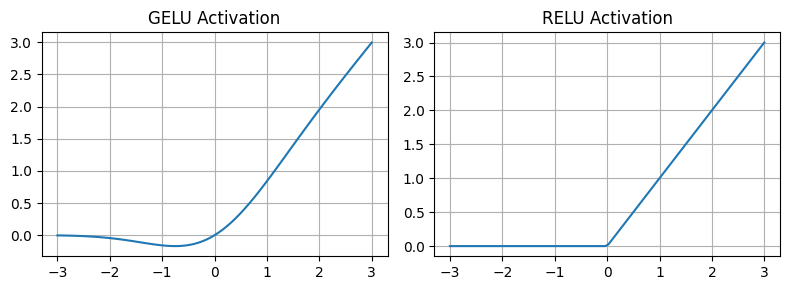

In [ ]:
import matplotlib.pyplot as plt
gelu,relu = GELU(), nn.ReLU()

x = torch.linspace(-3,3,100)
y_gelu,y_relu = gelu(x),relu(x)
plt.figure(figsize=(8, 3))
# y_gelu.shape
for i,(y,label) in enumerate(zip([y_gelu,y_relu],['GELU','RELU']),1):
  plt.subplot(1,2,i)
  plt.plot(x,y)
  plt.title(f'{label} Activation')
  plt.grid()
plt.tight_layout()

In [ ]:
relu(torch.tensor([-1,-1,-1]))
gelu(torch.tensor([-2,-2,-2]))

tensor([-0.0454, -0.0454, -0.0454])

In [ ]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layer = nn.Sequential(nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']) ,GELU(),nn.Linear(4* cfg['emb_dim'],cfg['emb_dim']))

  def forward(self,x):
    return self.layer(x)

test = torch.randn([2,3,768])

tc = FeedForward(CFG)
tc(test).shape

torch.Size([2, 3, 768])

In [ ]:
# neural shortcut
class ExampleDNN(nn.Module):
  def __init__(self,layer_size,use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([nn.Sequential(nn.Linear(layer_size[0],layer_size[1]),GELU()),
                            nn.Sequential(nn.Linear(layer_size[1],layer_size[2]),GELU()),
                            nn.Sequential(nn.Linear(layer_size[2],layer_size[3]),GELU()),
                            nn.Sequential(nn.Linear(layer_size[3],layer_size[4]),GELU()),
                            nn.Sequential(nn.Linear(layer_size[4],layer_size[5]),GELU())
                            ])

  def forward(self,x):
    for layer in self.layers:
      layer_output = layer(x)
      if self.use_shortcut == True:
        x = x+layer_output
      else:
        x= layer_output
    return x

layer_size = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,1.]])
# sample_input.dtype
torch.manual_seed(123)
Enoshort = ExampleDNN(layer_size,False)
Eshort = ExampleDNN(layer_size,True)
Enoshort(sample_input)


def printgradient(model,x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = torch.nn.MSELoss()
  loss = loss(output,target)
  loss.backward()

  for name,param in model.named_parameters():
    # if 'weight' in name:
      print(name,param.grad.abs().mean().item())

printgradient(Eshort,sample_input)


layers.0.0.weight 0.5671719908714294
layers.0.0.bias 0.8507580757141113
layers.1.0.weight 0.47776636481285095
layers.1.0.bias 0.5876272916793823
layers.2.0.weight 0.6719534397125244
layers.2.0.bias 0.820436954498291
layers.3.0.weight 0.7111383080482483
layers.3.0.bias 0.7866613864898682
layers.4.0.weight 0.7011792063713074
layers.4.0.bias 0.4635065793991089


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


##0715-Put all together

##Everything

In [ ]:
CFG = {
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,
    "n_layers":12,
    "dropout_rate":0.1,
    "qkv_bias":False}

class MHA(nn.Module):
  def __init__(self,num_head,din,dout,dropout,context_length):
    assert(dout%num_head == 0), "dout%num_head == 0"
    super().__init__()

    self.context_length =context_length
    self.head_dim = dout//num_head
    self.dout = dout
    self.din = din
    self.num_head = num_head

    self.out_proj = nn.Linear(dout, dout)
    self.wq = nn.Linear(din,dout,bias=False)
    self.wk = nn.Linear(din,dout,bias=False)
    self.wv = nn.Linear(din,dout,bias=False)
    self.register_buffer('mask',torch.triu(torch.ones([context_length,context_length]),diagonal=1))
    self.dropout = nn.Dropout(dropout)
  def forward(self,x):
    b,num_token,din = x.shape
    q = self.wq(x)
    k = self.wk(x)
    v = self.wv(x)


    q = q.view(b,num_token,self.num_head,self.head_dim)
    k = k.view(b,num_token,self.num_head,self.head_dim)
    v = v.view(b,num_token,self.num_head,self.head_dim)


    q = q.transpose(1, 2)
    k = k.transpose(1, 2)
    v = v.transpose(1, 2)

    attn_score = q @ k.transpose(2,3)
    attn_score = attn_score.masked_fill(self.mask.bool()[:num_token,:num_token],-torch.inf)
    attn_weights = torch.softmax(attn_score/k.shape[-1]**0.5,dim=-1)
    attn_weights = self.dropout(attn_weights)
    con_vec = attn_weights @ v
    con_vec.transpose_(1,2)
    con_vec = con_vec.contiguous().view(b,num_token,self.dout)
    con_vec = self.out_proj(con_vec)
    return con_vec

class NormLayer(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones((emb_dim)))
    self.shift = nn.Parameter(torch.zeros((emb_dim)))

  def forward(self,x):
    mean = x.mean(keepdim=True,dim=-1)
    var = x.var(keepdim=True,dim=-1,unbiased=False)
    out_norm = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale*out_norm + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layer = nn.Sequential(nn.Linear(cfg['emb_dim'],4*cfg['emb_dim']) ,GELU(),nn.Linear(4* cfg['emb_dim'],cfg['emb_dim']))

  def forward(self,x):
    return self.layer(x)

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att = MHA(cfg['n_heads'],cfg['emb_dim'],cfg['emb_dim'],cfg['dropout_rate'],cfg['context_length'])
    self.ff = FeedForward(cfg)
    self.norm1 = NormLayer(cfg['emb_dim'])
    self.norm2 = NormLayer(cfg['emb_dim'])
    self.drop_shotcut = nn.Dropout(cfg['dropout_rate'])

  def forward(self,x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shotcut(x)
    x=x+shortcut

    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shotcut(x)
    x=x+shortcut
    return x



class GPT(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.drop_emb =nn.Dropout(cfg['dropout_rate'])
    self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.final_norm=NormLayer(cfg['emb_dim'])
    self.out_head = nn.Linear(cfg['emb_dim'],cfg['vocab_size'],bias=False)

  def forward(self,in_idx):
    batch_size,seq_len = in_idx.shape
    tok_embeds=self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits



torch.manual_seed(123)
model = GPT(CFG)

batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'
batch.append(torch.tensor(tk.encode(txt1)))
batch.append(torch.tensor(tk.encode(txt2)))
batch = torch.stack(batch,dim=0)

out = model(batch)
# print("Input batch:\n", batch)
# print("\nOutput shape:", out.shape)
out.shape

params = sum([p.numel() for p in model.parameters()])
params - sum([p.numel() for p in model.out_head.parameters()])

124412160

In [ ]:
model.tok_emb.weight.shape
model.out_head.weight.shape

torch.Size([50257, 768])

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length),diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)


        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = NormLayer(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'
batch.append(torch.tensor(tk.encode(txt1)))
batch.append(torch.tensor(tk.encode(txt2)))
batch = torch.stack(batch,dim=0)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
out.shape

# params = sum([p.numel() for p in model.parameters()])
# params

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])


torch.Size([2, 4, 50257])

##test 0717, warp up

##GPT-forward

In [ ]:
class GPTforward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_emb = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.dropout = nn.Dropout(cfg['drop_rate'])
    self.tb = nn.ModuleList([TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
    self.finalNorm = NormLayer(cfg['emb_dim'])




  def forward(self,x):
    b,seq_len = x.shape
    t_emb = self.tok_emb(x)
    p_emb = self.pos_emb(torch.arange(seq_len,device=x.device))
    xx = t_emb+p_emb
    xx = self.dropout(xx)
    for i in self.tb:
      xx = i(xx)
    xx = self.finalNorm(xx)

    return xx




##MHA


In [ ]:
class MHA(nn.Module):
    # def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    def __init__(self, d_in, d_out, num_heads,context_length,dropout, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.head_dim = d_out//num_heads
        self.wq = nn.Linear(d_in,d_out,qkv_bias)
        self.wk = nn.Linear(d_in,d_out,qkv_bias)
        self.wv = nn.Linear(d_in,d_out,qkv_bias)
        self.num_heads = num_heads
        self.register_buffer('mask',torch.triu(torch.ones((context_length,context_length)),1))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
      b,seq_len,emb_dim = x.shape
      q = self.wq(x)
      k = self.wk(x)
      v = self.wv(x)

      # batch, seq_len, num_head,head_dim
      q = q.view(b,seq_len,self.num_heads,self.head_dim)
      k = k.view(b,seq_len,self.num_heads,self.head_dim)
      v = v.view(b,seq_len,self.num_heads,self.head_dim)

      # batch, num_head, seq_len,head_dim
      q = q.transpose(1,2)
      k = k.transpose(1,2)
      v = v.transpose(1,2)


      # # q:batch, num_head, seq_len,head_dim, k:q:batch, num_head,head_dim, seq_len
      # # -->batch, num_head,seq_len,seq_len
      att_score = q @ k.transpose(2,3)
      att_score.masked_fill_(mask[:seq_len,:seq_len].bool(),-torch.inf)

      # # -->att_weight: batch, num_head,seq_len,seq_len, v:batch, num_head, seq_len,head_dim
      att_weight = torch.softmax(att_score/k.shape[-1]**0.5,dim = -1)

      # -->con_vec: batch, num_head,seq_len,head_dim
      con_vec = att_weight @ v

      # -->con_vec:batch, seq_len,num_head,head_dim
      con_vec = con_vec.transpose(1,2)

      con_vec = con_vec.contiguous().view(b,seq_len,self.d_out)

      return con_vec


##Layer_Norm

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.ones(emb_dim))

    def forward(self, x):
      mean = x.mean(dim=1,keepdim=True)
      var = x.var(dim=1,keepdim=True)
      n_x = ((x-mean)/torch.sqrt(var+self.eps))
      return self.scale*n_x+self.shift

##GELU

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


##FF

In [ ]:
class FeedForward(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.block = nn.Sequential(
        nn.Linear(emb_dim,4*emb_dim),
        GELU(),
        nn.Linear(4*emb_dim,emb_dim)
    )
  def forward(self,x):
    return self.block(x)


##Transformer Block

In [ ]:



class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.a = nn.Sequential(
        NormLayer(cfg["emb_dim"]),
        MHA(cfg["emb_dim"],cfg["emb_dim"],cfg["n_heads"],cfg["context_length"],cfg["drop_rate"],cfg["qkv_bias"]),
        nn.Dropout(cfg['drop_rate']))

    self.b = nn.Sequential(
        NormLayer(cfg["emb_dim"]),
        FeedForward(cfg['emb_dim']),
        nn.Dropout(cfg['drop_rate']))

  def forward(self,x):
    block_a = self.a(x)+x
    block_b = self.b(block_a)+block_a
    return block_b



##Before Here

In [ ]:
# test

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)
batch = torch.stack((inputs,inputs))






# class TransformerBlock(nn.Module):
#     def __init__(self, cfg):
#         super().__init__()
#     def forward(self, x):

#         return x

# class GPTModel(nn.Module):
#     def __init__(self, cfg):

#     def forward(self, in_idx):
#         return





In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'
batch.append(torch.tensor(tk.encode(txt1)))
batch.append(torch.tensor(tk.encode(txt2)))
batch = torch.stack(batch,dim=0)

out = model(batch)
# print("Input batch:\n", batch)
# print("\nOutput shape:", out.shape)
out.shape

params = sum([p.numel() for p in model.parameters()])
params

NameError: name 'mask' is not defined

##Generating text 0724

In [ ]:
# # run above code ,load the standard GPT model
# model = GPTModel(GPT_CONFIG_124M)
# def generate_text_sample(model,idx, max_new_tokens,context_size ):
#   a = []
#   for _ in range(max_new_tokens):
#     idx_cond = idx[:,-context_size:]
#     with torch.no_grad():
#       logits=model(idx_cond)
#     logits = logits[:,-1,:]
#     probas = torch.softmax(logits,dim=-1)
#     id_next = torch.argmax(probas,dim=-1,keepdim=True)
#     idx = torch.cat((idx,id_next),dim=-1)
#   # return logits
#   # return probas
#   return idx

# # def generate_text_sample(idx, max_new_tokens=6,context_size=5 ):
# #   print(idx[:,-context_size:])

# start_text = 'Hello, I am '
# encoded = tk.encode(start_text)
# encoded_tensor = torch.tensor(encoded).unsqueeze(0)
# model.eval()
# out = generate_text_sample(model,encoded_tensor,max_new_tokens=10,context_size=CFG['context_length'])
# print(out)
# print(tk.decode(out.squeeze(0).tolist()))
# # generate_text_sample(model,encoded_tensor,max_new_tokens=6,context_size=3)

# # len(generate_text_sample(model,encoded_tensor,max_new_tokens=6,context_size=3)

# start_text = 'Hello, I am '
# encoded = tk.encode(start_text)
# encoded_tensor = torch.tensor(encoded).unsqueeze(0)
# model.eval()
# out = generate_text_sample(model,encoded_tensor,max_new_tokens=10,context_size=CFG['context_length'])
# print(out)
# print(tk.decode(out.squeeze(0).tolist()))
# # generate_text_sample(model,encoded_tensor,max_new_tokens=6,context_size=3)

# # len(generate_text_sample(model,encoded_tensor,max_new_tokens=6,context_size=3)

###small tips about cat and stack

In [ ]:
a = torch.tensor(([1,2,3],[4,5,6],[7,8,9],[10,11,12]))
b = torch.tensor(([81,82,83],[84,85,86],[87,88,89],[90,91,92]))
a.shape,b.shape
torch.stack((a,b),dim=0),torch.stack((a,b),dim=0).shape,
# torch.stack((a,b),dim=0).shape,  torch.cat((a,b),dim=0).shape
# torch.stack((a,b),dim=2)
# torch.cat((a,b),dim=2)

###here0724

In [ ]:
# start_text = 'Hello, I am '
# encoded = tk.encode(start_text)
# encoded_tensor = torch.tensor(encoded).unsqueeze(0)
# model.eval()
# out = generate_text_sample(model,encoded_tensor,max_new_tokens=10,context_size=CFG['context_length'])
# print(out)
# print(tk.decode(out.squeeze(0).tolist()))
# generate_text_sample(model,encoded_tensor,max_new_tokens=6,context_size=3)

# len(generate_text_sample(model,encoded_tensor,max_new_tokens=6,context_size=3))


###test0724

In [ ]:

a =nn.Embedding(10000,3)
b = nn.Embedding(4,3)
a(batch), b(torch.arange(4))

# batch

In [ ]:
#####################Play Ground######################################################Play Ground#################################
#####################Play Ground######################################################Play Ground#################################

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)

)
batch = torch.stack((inputs,inputs))
testa = inputs[0].unsqueeze(0)
testb = torch.stack((inputs[0],inputs[1]))

# a = LayerNorm(3)
# a = GELU()
# a(testb),testb

# torch.manual_seed(123)
# a = MHA(3,10,dropout=0,context_length=15,num_heads=2)
# batch.shape,a(batch).shape

# for name, param in a.named_parameters():
#     print(name, param.shape)
# for name, buf in a.named_buffers():
#     print(name, buf.shape)

# a = nn.Linear(3,4,bias=False)
# for c,d in a.named_parameters():
#   print('Linearw',d.shape)

# print('b',testb.shape),
# print('a(b)',a(testb).shape)
# a = FeedForward(3)
# a(testb),a(testb).shape
# a = NormLayer(3)
# a = MHA(3,2,dropout=0,context_length=15,num_heads=2)
# a(batch).shape

# torch.manual_seed(123)
# GPT_test = torch.rand(2,4,768)
# TB = TransformerBlock(gd)
# TB(GPT_test).shape

# a = torch.tensor([[0, 0, 0,  0],
#                   [0, 0, 0,  0],
#                   [0, 0, 0,  0]])
# t = torch.stack((a,a))
# b = torch.tensor([[1, 1, 1,  1],
#                   [1, 1, 1,  1],
#                   [1, 1, 1,  1]])

# t+b


gd = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

tk = tiktoken.get_encoding('gpt2')
test_txt =  ['Every effort moves you' ,'Every day holds a']
GPT_input = torch.tensor([tk.encode(i) for i in test_txt])
# GPT_input

a = GPTforward(gd)
a(GPT_input).shape

pnum = sum(p.numel() for p in a.parameters())
pnum

##Chapter5 Recap 0801

In [ ]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)

)
batch = torch.stack((inputs,inputs))

In [ ]:
import torch
from torch import nn as nn
import tiktoken
tk = tiktoken.get_encoding('gpt2')
gd = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}



###MHA0801

In [ ]:
class MHA(nn.Module):
  def __init__(self,d_in,d_out,qkv_bias,num_head,context_len,drop):
    super().__init__()
    self.num_head = num_head
    self.d_out = d_out
    self.head_dim = d_out // num_head
    self.dropout = nn.Dropout(drop)
    assert (d_out % num_head == 0), "d_out must be divisible by num_heads"
    self.wq = nn.Linear(d_in,d_out,bias=qkv_bias)
    self.wk = nn.Linear(d_in,d_out,bias=qkv_bias)
    self.wv = nn.Linear(d_in,d_out,bias=qkv_bias)
    self.register_buffer('mask',torch.triu(torch.ones(context_len,context_len),1))
    self.out_proj = nn.Linear(d_out, d_out)


  def forward(self,x):
    b,num_token,d_in = x.shape
    q = self.wq(x)
    k = self.wk(x)
    v = self.wv(x)
    q = q.view(b,num_token,self.num_head,self.head_dim) #b,context_len,num_head,head_dim
    k = k.view(b,num_token,self.num_head,self.head_dim) #b,context_len,num_head,head_dim
    v = v.view(b,num_token,self.num_head,self.head_dim) #b,context_len,num_head,head_dim

    q = q.transpose(1,2) #b,num_head,context_len,head_dim
    k = k.transpose(1,2) #b,num_head,context_len,head_dim
    v = v.transpose(1,2) #b,num_head,context_len,head_dim

    att_score = q @ k.transpose(2,3)
    mask_bool = self.mask.bool()[:num_token, :num_token]
    att_score = att_score.masked_fill(mask_bool,-torch.inf)
    att_weight = torch.softmax(att_score,dim=-1)
    con_vec = att_weight @ v
    con_vec = self.dropout(con_vec)
    con_vec = con_vec.transpose(1,2)
    con_vec = con_vec.contiguous().view(b,num_token,self.d_out)
    con_vec = self.out_proj(con_vec)


    return con_vec

a = MHA(3,10,False,2,context_len=100,drop=0.5)
a(batch).shape

###NormLayer0801

In [ ]:
class NormLayer(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.ones(emb_dim))
    self.eps = 1e-5

  def forward(self,x):
    mean = torch.mean(x,dim=-1,keepdim=True)
    var = torch.var(x,dim=-1,keepdim=True)
    norm_x = (x - mean) / torch.sqrt(var + self.eps)
    return self.scale * norm_x + self.shift


inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)

)
batch = torch.stack((inputs,inputs))
a = NormLayer(3)
a(inputs)[0].var()

###GELU

In [ ]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

###FF

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

###NS

#**Chapter 5**

In [ ]:
import torch
from torch import nn as nn
import tiktoken
tk = tiktoken.get_encoding('gpt2')

##gptModel

In [ ]:
gd = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length),diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)


        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec


class NormLayer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = NormLayer(cfg["emb_dim"])
        self.norm2 = NormLayer(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = NormLayer(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



torch.manual_seed(123)
model = GPTModel(gd)

batch = []
txt1 = 'Every effort moves you'
txt2 = 'Every day holds a'
batch.append(torch.tensor(tk.encode(txt1)))
batch.append(torch.tensor(tk.encode(txt2)))
batch = torch.stack(batch,dim=0)
(batch.shape)
out = model(batch)
# print("Input batch:\n", batch)
# print("\nOutput shape:", out.shape)
# out.shape

# params = sum([p.numel() for p in model.parameters()])
# params

In [ ]:
batch.shape

torch.Size([2, 4])

##shortcut0731

In [ ]:
def generate_text(model, idx,max_new,context_size):
  a = []
  for _ in range(max_new):
    id_cond = idx[:,-context_size:]
    out = model(id_cond)
    last = out[:,-1,:]
    probas = torch.softmax(last,dim=-1)
    id_next = torch.argmax(probas,keepdim=True)
    idx = torch.cat((idx, id_next), dim=-1)
  return idx



def text2token(text):
  tik = tk
  encode = tik.encode(text,allowed_special={'<|endoftext|>'})
  encode = torch.tensor(encode)
  encode= encode.unsqueeze(0)
  return encode

def token2text(token):
  tik = tk
  token=token.squeeze(0)
  token = token.tolist()
  decode = tik.decode(token)
  return decode
a = 'Every effort moves you'
b = text2token(a)
c = token2text(b)
c

'Every effort moves you'

In [ ]:
gd = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}
torch.manual_seed(123)
model = GPTModel(gd)
# model.eval()



In [ ]:
tids = generate_text(model,text2token('Every effort moves you'),10,gd['context_length'])
token2text(tids)

'Every effort moves you Samoa parad Defensive MacBook Referospace preparation Einstein ShepherdMot'

In [ ]:
#manual CE
inputs1 = text2token('every effort moves')
inputs2 = text2token('I really like')
target1 = text2token(' effort moves you')
target2 = text2token(' really like chocolate')

inputs = torch.cat((inputs1,inputs2),dim=0)
targets = torch.cat((target1,target2),dim=0)

inputs,targets

with torch.no_grad():
  logits = model(inputs)
probas = torch.softmax(logits,dim=-1)
probas.shape,logits.shape
# # probas.shape
target_probas_1 = probas[0,[0,1,2],targets[0]]
target_probas_2 = probas[1,[0,1,2],targets[1]]

print(target_probas_1)
print(target_probas_2)
log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
neg_avg = -log_probas.mean()
neg_avg
# log_probas


tensor([4.0363e-05, 2.7361e-05, 1.1445e-05])
tensor([8.2989e-06, 9.1948e-05, 6.1120e-06])


tensor(10.8335)

In [ ]:
# torch.manual_seed(123)
# a = torch.randn((2,3,5))
# a
# a.flatten(0,1)
# a.contiguous().view(6,5)

In [ ]:
#auto CE
logits.shape,targets.shape
l_flat = logits.flatten(0,1)
# l_flat = logits.contiguous().view(6,50257)
t_flat = targets.flatten(0,1)
# t_flat = targets.contiguous().view(6)
l_flat.shape,t_flat.shape
ce = nn.CrossEntropyLoss()
loss = ce(l_flat,t_flat)
# loss = nn.functional.cross_entropy(l_flat,t_flat)
loss
torch.exp(loss)

tensor(50689.4570)

##text generator

In [ ]:
def generate_text_sample(model,idx, max_new_tokens,context_size ):
  a = []
  for _ in range(max_new_tokens):
    idx_cond = idx[:,-context_size:]
    with torch.no_grad():
      logits=model(idx_cond)
    logits = logits[:,-1,:]
    probas = torch.softmax(logits,dim=-1)
    id_next = torch.argmax(probas,dim=-1,keepdim=True)
    idx = torch.cat((idx,id_next),dim=-1)
  return idx

def t2to(txt,tok=tk):
  encoded=tok.encode(txt,allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def to2t(tid,tok=tk):
  tid = tid.squeeze(0)
  decoded=tok.decode(tid.tolist())
  return decoded



In [ ]:
gd = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}
torch.manual_seed(123)
model = GPTModel(gd)
model.eval()
tids = generate_text_sample(model,t2to('Every effort moves you'),10,gd['context_length'])
to2t(tids)

'Every effort moves you rentingetic wasnم refres RexMeCHicular stren'

In [ ]:
torch.set_printoptions(sci_mode=False)

##CE

In [ ]:
#manual CE
inputs1 = t2to('every effort moves')
inputs2 = t2to('I really like')
t1 = t2to(' effort moves you')
t2 = t2to(' really like chocolate')

inputs = torch.cat((inputs1,inputs2),dim=0)
targets = torch.cat((t1,t2),dim=0)

inputs.shape

# targets
# with torch.no_grad():
#   logits = model(inputs)
# probas = torch.softmax(logits,dim=-1)

# # probas.shape
# target_probas_1 = probas[0,[0,1,2],targets[0]]
# target_probas_2 = probas[1,[0,1,2],targets[1]]

# # print(target_probas_1)
# # print(target_probas_2)
# log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
# neg_avg = -log_probas.mean()
# neg_avg

torch.Size([2, 3])

In [ ]:
#auto CE
logits.shape,targets.shape
l_flat = logits.flatten(0,1)
t_flat = targets.flatten(0,1)
# loss = nn.cross_entropy(l_flat,t_flat)
# ce = nn.CrossEntropyLoss()
# loss = ce(l_flat,t_flat)
loss = nn.functional.cross_entropy(l_flat,t_flat)
loss
# torch.exp(loss)

tensor(10.8335)

##dataloader

In [ ]:
# a = torch.arange(11)
# ws = 3
# stride = 2
# for i in range(0,len(a)-ws,stride):
#   print(a[i:i+ws])
#   print(a[i+1:i+ws+1])
#   print()
# len(a)-ws

In [ ]:
from torch.utils.data import Dataset,DataLoader
class DatasetGPT(Dataset):
  def __init__(self,txt,tokenizer,window_size,stride):
    super().__init__()
    self.input_idx = []
    self.target_idx = []
    token = tokenizer.encode(txt)
    for i in range(0, len(token)-window_size,stride):
      input_chunk=token[i:i+window_size]
      target_chunk=token[i+1:i+window_size+1]
      self.input_idx.append(torch.tensor(input_chunk))
      self.target_idx.append(torch.tensor(target_chunk))


  def __getitem__(self,i):
    return self.input_idx[i],self.target_idx[i]

  def __len__(self):
      return len(self.input_idx)


def dataloaderV2(txt,batch_size,window_size,stride,shuffle=True,drop_last=True,num_workers=0):
  dataset = DatasetGPT(txt,tk,window_size,stride)
  dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
  return dataloader





##data

In [ ]:
with open('the-verdict.txt','r',encoding='utf-8') as f:
  raw = f.read()
raw

split_idx = int(0.9*len(raw))
train_data = raw[:split_idx]
valid_data = raw[split_idx:]

train_loader = dataloaderV2(train_data,batch_size=2,window_size=gd['context_length'],stride=gd['context_length'],drop_last=True,shuffle=True,num_workers=0)
valid_loader = dataloaderV2(valid_data,batch_size=2,window_size=gd['context_length'],stride=gd['context_length'],drop_last=False,shuffle=False,num_workers=0)
# x,y = next(iter(train_loader))
# token2text(x[0]),token2text(y[0])

In [ ]:
for x,y in train_loader:
  print(x.shape,y.shape)
print()
for x,y in valid_loader:
  print(x.shape,y.shape)

len(train_loader)

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

torch.Size([2, 256]) torch.Size([2, 256])


9

In [ ]:
def closs(in_batch,tar_batch,model,device):
  in_batch = in_batch.to(device)
  tar_batch = tar_batch.to(device)
  model = model.to(device)
  logit = model(in_batch)
  # logit = logit.flatten(0,1)
  # tar = tar_batch.flatten()
  loss = torch.nn.functional.cross_entropy(logit.flatten(0,1),tar_batch.flatten())
  return loss

def closs_loader(dataload,model,device,num_batch):
  total_loss = 0
  model = model.to(device)
  if len(dataload)==0:
    return float('nan')
  elif num_batch==None:
    num_batch=len(dataload)
  else:
    num_batch = min(num_batch,len(dataload))
  for i,(x,y) in enumerate(dataload):
    if i<num_batch:
      loss = closs(x,y,model,device)
      total_loss+=loss.item()
    else:
      break
  return total_loss/num_batch
x,y = next(iter(train_loader))
device = 'cuda' if (torch.cuda.is_available()) else 'cpu'
torch.manual_seed(123)
model=GPTModel(gd)
# model(x).shape, y.shape
closs(x,y,model,device)
x.numel(),y.numel()
# with torch.no_grad():
#   tl = closs_loader(train_loader,model,device,num_batch=None)
#   vl = closs_loader(valid_loader,model,device,num_batch=None)
# print(tl,vl)

(512, 512)

In [ ]:
def calc_loss(input_batch,target_batch,model,device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
  return loss

def calc_loss_loader(data_loader,model,device,num_batch=None):
  total_loss=0
  if len(data_loader) == 0:
    return float('nan')
  elif num_batch is None:
    num_batch = len(data_loader)
  else:
    num_batch = min(num_batch,len(data_loader))
  for i,(ib,tb) in enumerate(data_loader):
    if i< num_batch:
      loss = calc_loss(ib,tb,model=model,device=device)
      total_loss+=loss.item()
    else:
      break
  return total_loss/num_batch

device = 'cuda' if (torch.cuda.is_available()) else 'cpu'
torch.manual_seed(123)
model=GPTModel(gd)
model.to(device)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader,model,device)
  valid_loss = calc_loss_loader(valid_loader,model,device)

print(train_loss)
print(valid_loss)


10.987917476230198
10.976283073425293


##playgroundCP5

In [ ]:
inputs1 = t2to('every effort moves')
inputs2 = t2to('I really like')
inputs = torch.cat((inputs1,inputs2),dim=0)
inputs
# inputs4 = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
#                        [40,    1107, 588]])   #  "I really like"]

t1 = t2to(' effort moves you')
t2 = t2to(' really like chocolate')
# t1,t2
targets = torch.cat((t1,t2),dim=0)

#**Chapter 5 (rebuild)**

In [ ]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 2.0.2
tiktoken version: 0.11.0
torch version: 2.8.0+cu126
tensorflow version: 2.19.0


In [ ]:
# 1 ############write by own
import torch
GPT_CONFIG_124M = {
    'vocab_size':50257,
    'context_length':256,
    'emb_dim':768,
    'n_heads':12,
    'n_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False
}
torch.manual_seed(123)
model=GPTModel(GPT_CONFIG_124M)
model = model.to('cpu')
model.eval()
#############write by own

KeyboardInterrupt: 

In [ ]:
# 2 ############write by own
import tiktoken
def text2token(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor
def token2text(token,tokenizer):
  flat = token.squeeze(0)
  text = tokenizer.decode(flat.tolist())
  return text

def generate_t_sample(model,idx,context_size,max_generate):
  for _ in range(max_generate):
    id_calc = idx[:,-context_size:]
    with torch.no_grad():
      logits = model(id_calc)
      probas = torch.softmax(logits,dim=-1)
      focus = probas[:,-1,:]
      id_next = torch.argmax(focus,keepdim=True)
      idx = torch.cat((idx,id_next),dim=-1)
  return idx


start_text = 'Every effort moves you'
tk = tiktoken.get_encoding('gpt2')
tokens = generate_t_sample(model,text2token(start_text,tk),GPT_CONFIG_124M['context_length'],10)
token2text(tokens,tk)
#############write by own
# a = text2token(start_text,tk)

# out = model(a)
# probas = torch.softmax(out,dim=-1)
# torch.argmax(probas[:,-1,:],keepdim=True).shape

In [ ]:
# 3 ############write by own
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]
#############write by own
# token2text(inputs[0],tk)

In [ ]:
# 4 ############write by own
with torch.no_grad():
  logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)
#############write by own

In [ ]:
# 5 ############write by own
token_ids = torch.argmax(probas,dim=-1,keepdim=True)
print(token_ids)
#############write by own
token2text(token_ids[0].flatten(),tk)
# token_ids[0].flatten()

In [ ]:
# 6 ############write by own
print(token2text(targets[0],tk))
print(token2text(token_ids[0].flatten(),tk))
#############write by own

In [ ]:
# 7 ############write by own
text_idx = 0
target_probas_1 = probas[text_idx,[0,1,2],targets[text_idx]]
text_idx = 1
target_probas_2 = probas[text_idx,[0,1,2],targets[text_idx]]

target_probas_1.shape
target_probas_2.shape
target_probas_1,target_probas_2
#############write by own
# targets[0].shape
target_probas_1.shape,target_probas_2.shape

In [ ]:
# 8 ############write by own
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)
#############write by own

In [ ]:
# 9  ############write by own
avg_log_probas = torch.mean(log_probas)
avg_log_probas
#############write by own

In [ ]:
# 10 ############write by own
# cross enotropy(for one-hot):H(P,Q)=−logq
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)
#############write by own

In [ ]:
# 11 ############write by own
print(logits.shape)
print(targets.shape)

#############write by own

In [ ]:
# 12 ############write by own
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
#############write by own
logits_flat,targets_flat

In [ ]:
## 13 ###########write by own
loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
loss
#############write by own

In [ ]:
# 14 ############write by own
preplexity = torch.exp(loss)
preplexity
#############write by own

In [ ]:
# 15 ############write by own
with open('the-verdict.txt', "r", encoding="utf-8") as file:
    text_data = file.read()
#############write by own

In [ ]:
# 16 ############write by own
print(text_data[:99])
print(text_data[-99:])
#############write by own

In [ ]:
# 17 ############write by own
total_characters = len(text_data)
total_tokens = len(tk.encode(text_data))
#############write by own

In [ ]:
# 18 ############write by own
from torch.utils.data import Dataset,DataLoader
class DatasetGPT(Dataset):
  def __init__(self,txt,window_size,stride,tokenizer=tk):
    super().__init__()
    enc = tk.encode(txt)
    self.x = []
    self.y = []
    for i in range(0,len(enc)-window_size,stride):
      xx = enc[i:i+window_size]
      yy = enc[i+1:i+window_size+1]
      self.x.append(torch.tensor(xx))
      self.y.append(torch.tensor(yy))
  def __len__(self):
    return len(self.x)

  def __getitem__(self,index):
    return self.x[index],self.y[index]

def dataloaderV2(txt,batch_size,window_size,stride,shuffle=True,drop_last=True,num_workers=0):
  dataset = DatasetGPT(txt=txt,window_size=window_size,stride=stride)
  dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
  return dataloader
#############write by own

In [ ]:
# 19 ############write by own
train_ratio=0.9
split_idx = int(train_ratio*len(text_data))
train_data = text_data[:split_idx]
valid_data = text_data[split_idx:]
train_loader = dataloaderV2(train_data,batch_size=2,window_size=GPT_CONFIG_124M['context_length'],stride=GPT_CONFIG_124M['context_length'],drop_last=True,shuffle=True,num_workers=0)
valid_loader = dataloaderV2(valid_data,batch_size=2,window_size=GPT_CONFIG_124M['context_length'],stride=GPT_CONFIG_124M['context_length'],drop_last=False,shuffle=False,num_workers=0)
#############write by own

In [ ]:
# 20 ############write by own
for x,y in train_loader:
  print(x.shape,y.shape)

print()
for x,y in valid_loader:
  print(x.shape,y.shape)
len(train_loader)
#############write by own
# for i,(x,y) in enumerate(train_loader):
#   if i==1:
#     break
#   xxx = x
#   yyy = y
  # print(x.shape,y.shape)
  # print(x,y)
# xxx[0],yyy[0] # matched

In [ ]:
# 21 ############write by own
train_tokens=0
for x,y in train_loader:
  train_tokens+=x.numel()

valid_tokens=0
for x,y in valid_loader:
  valid_tokens+=x.numel()
train_tokens,valid_tokens
#############write by own

In [ ]:
# 22 ############write by own
def cal_loss_batch(inp,tar,model,device):
  inp = inp.to(device)
  tar = tar.to(device)
  logits = model(inp)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),tar.flatten())
  return loss

def cal_loss_loader(dataloader,model,device,num_batch=None):
  total_loss = 0
  if num_batch==0:
    return float('nan')
  elif num_batch == None:
    num_batch = len(dataloader)
  else:
    num_batch = min(len(dataloader),num_batch)
  for i, (inp,tar) in enumerate(dataloader):
    if i>= num_batch:
      break
    else:
      total_loss+=cal_loss_batch(inp,tar,model,device).item()
  return total_loss/num_batch
#############write by own

In [ ]:
# 23 ############write by own
# cal_loss_loader(dataloader,model,device,num_batch=None):
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

with torch.no_grad():
  train_loss = cal_loss_loader(train_loader,model,device)
  valid_loss = cal_loss_loader(valid_loader,model,device)

print("Training loss:", train_loss)
print("Validation loss:", valid_loss)
#############write by own

In [ ]:
# tk = tiktoken.get_encoding('gpt2')
# context_size = model.pos_emb.weight.shape[0]
# start_text = 'hello'
# start_text = text2token(start_text,tk).to(device)
# start_text
# a = generate_text(model,idx=start_text,max_new=50,context_size=context_size)
# a
# token2text(a,tk)

In [ ]:
def gen_sample(model,device,start_text,tokenizer):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  start_text = text2token(start_text,tokenizer).to(device)
  with torch.no_grad():
    # (model,idx=start_text,max_new=50,context_size=context_size)
    gt = generate_t_sample(model,idx=start_text,context_size=context_size,max_generate=50)
    decoded_text = token2text(gt, tokenizer)
    return decoded_text
gen_sample(model,device,start_text='hello',tokenizer=tk)

In [ ]:
# 22 ############write by own
def gen_sample(model,device,start_text,tokenizer,max_generate=50):
  model.eval()
  context_size = model.pos_emb.weight.shape[0]
  start_text = text2token(start_text,tokenizer).to(device)
  with torch.no_grad():
    gt = generate_t_sample(model,idx=start_text,context_size=context_size,max_generate=max_generate)
    decoded_text = token2text(gt, tokenizer)
    print(decoded_text.replace("\n", " "))
  model.train()

def eval_model(model,train_loader,valid_loader,device,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = cal_loss_loader(train_loader,model,device,num_batch=eval_iter)
    valid_loss = cal_loss_loader(valid_loader,model,device,num_batch=eval_iter)
  model.train()
  return train_loss,valid_loss

def train_model(train_loader,valid_loader,model,num_epochs,optimizer,device,eval_freq,eval_iter,tokenizer,start_context):
  train_losses,valid_losses,track_token_seen = [],[],[]
  tokens_seen, global_step = 0, -1
  model.train()
  for e in range(num_epochs):
    for inp,tar in train_loader:
      optimizer.zero_grad()
      loss = cal_loss_batch(inp,tar,model,device)
      loss.backward()
      optimizer.step()
      tokens_seen += inp.numel()
      global_step+=1
      if global_step % eval_freq == 0:
        train_loss,valid_loss = eval_model(model,train_loader,valid_loader,device,eval_iter)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        track_token_seen.append(tokens_seen)
        print(f'Ep:{e+1} (Step {global_step}) Train loss:{train_loss} valid loss:{valid_loss}')
        gen_sample(model,device,start_context,tokenizer)
  return train_losses, valid_losses, track_token_seen


#############write by own
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
ef = len(train_loader)
tokenizer = tiktoken.get_encoding('gpt2')
num_epochs=10
train_losses, valid_losses, track_token_seen = train_model(train_loader,valid_loader,model,num_epochs,optimizer,device,eval_freq=ef,eval_iter=5,tokenizer=tokenizer,start_context='Every effort moves')


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    # ax1.legend(loc="upper right")
    # ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # # Create a second x-axis for tokens seen
    # ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    # ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    # ax2.set_xlabel("Tokens seen")

    # fig.tight_layout()  # Adjust layout to make room
    # plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, track_token_seen, train_losses, valid_losses)

In [ ]:
# 22 ############write by own
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_loss1(ep,tl,vl,ts):
  fig,ax1 = plt.subplots(figsize=(5,3))
  ax1.plot(ep,tl,label='tl')
  ax1.plot(ep,vl,linestyle='--',label='vl')
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax2 = ax1.twiny()
  ax2.plot(ts, tl, alpha=0)
  ax2.set_xlabel("token seen")


#############write by own
# num_epochs,len(train_losses),len(valid_losses),len(track_token_seen)
ep = torch.linspace(0, num_epochs, len(train_losses))
plot_loss1(ep,train_losses,valid_losses,track_token_seen)

In [ ]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
# (model=model,idx=text2token("Every effort moves you", tokenizer),max_new_tokens=25,context_size=GPT_CONFIG_124M["context_length"])
token_ids = generate_t_sample(model,idx=text2token('Every effort moves you',tokenizer),context_size=GPT_CONFIG_124M['context_length'],max_generate=20)
print("Output text:\n", token2text(token_ids, tokenizer))

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [ ]:
# 23 tempurture scale ############write by own
v = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
iv = {v:k for k,v in v.items()}

next_tokl = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
next_tokl.shape
#############write by own

In [ ]:
# 24 tempurture scale ############write by own
probas = torch.softmax(next_tokl,dim=-1)
def count_sample(logits):
  probas = torch.softmax(logits,dim=-1)
  torch.manual_seed(123)
  sample = [torch.multinomial(probas,num_samples=1).item() for _ in range(1000)]
  sampled_ids = torch.bincount(torch.tensor(sample))
  for i,freq in enumerate(sampled_ids):
    print(freq,iv[i])

def scale_temp(logits,temperature):
  scaled_logits = logits/temperature
  probas = torch.softmax(scaled_logits,dim=-1)
  return probas

temperatures = [1,0.1,5]
sp = [scale_temp(next_token_logits, T) for T in temperatures]
sptensor = torch.stack(sp)

x = torch.arange(len(v))
bw = 0.15
fig,ax = plt.subplots(figsize=(5,3))
for i,T in enumerate(temperatures):
  rect = ax.bar(x+i*bw,sp[i],bw,label = f'{T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(v.keys(), rotation=90)
ax.legend()

#############write by own

In [ ]:
#############write by own

#############write by own

In [ ]:
n = torch.topk(next_tokl,k=3)
# n
new_logits = torch.where(condition=next_token_logits<n[0][-1],input = torch.tensor(float('-inf')),other = next_token_logits)
new_logits
topk_probas = torch.softmax(new_logits,dim=-1)
topk_probas

In [ ]:
# 25 ############write by own
n = torch.topk(next_tokl,3)
cond = (next_tokl<n.values[-1])
cond
new = torch.where(cond,torch.tensor(float('-inf')),next_tokl)
torch.softmax(new,dim=-1)
#############write by own
# test = torch.tensor([1,2,3,4])
# cond = test>2
# torch.where(cond,test,0)


In [ ]:
# 26 ############write by own
def generate(model,device,start_text, max_new_tokens, tokenizer,context_size, temperature=0.0, top_k=None, eos_id=None):
  model.eval()
  idx = text2token(start_text,tokenizer).to(device)
  for _ in range(max_new_tokens):
    idx_cond =idx[:,-context_size:]
    with torch.no_grad():
      logits = model(idx_cond)
    care = logits[:,-1,:]
    if top_k>0:
      n = torch.topk(care,top_k, dim=-1)
      min_val = n.values[0][-1]
      mask = care >= min_val
      # return min_val.shape,care.shape,min_val
      care = torch.where(mask,torch.tensor(float('-inf')).to(care.device),care)

    if temperature>0:
      care = care/temperature
      probas = torch.softmax(care,dim=-1)
      next_token_idx = torch.multinomial(probas,num_samples=1)

    else:
      probas = torch.softmax(care,dim=-1)
      next_token_idx = torch.argmax(probas,dim=-1,keepdim=True)

    idx = torch.cat((idx,next_token_idx),-1)
  restext= token2text(idx,tokenizer)
  return restext.replace("\n", " ")



#############write by own


##load weight

In [ ]:
# 27 ############write by own
torch.save(model.state_dict(),'model.pth')
#############write by own

In [ ]:
# 28 ############write by own
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}
model_load = GPTModel(GPT_CONFIG_124M)
model_load.load_state_dict(torch.load('model.pth',map_location=device))
#############write by own

In [ ]:
# 29 ############write by own
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")
#############write by own

In [ ]:
# 30 ############write by own
print(settings)
print(params.keys())
print((params['wpe'].shape))
print(len(params['blocks']))
print((params['b'].shape))
print((params['blocks'][2].keys()))
#############write by own

In [ ]:
# 31 ############write by own
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},}

model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"qkv_bias": True})
NEW_CONFIG.update({"context_length":1024})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();
#############write by own

In [ ]:
# 32 ############write by own
def assign(left,right):
  if left.shape != right.shape:
    raise ValueError(f'Error, Left:{left.shape} Right:{right.shape}')
  else:
    return torch.nn.Parameter(torch.tensor(right))
#############write by own
# a = torch.tensor([1.0,1.0,1.0])
# b = torch.tensor([1.0,1.0,1.0])
# pb = assign(a,b),
# b,pb

In [ ]:
NEW_CONFIG

In [ ]:
#############write by own

#############write by own

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
#############write by own

#############write by own

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

In [ ]:
#############write by own
generate(model=gpt,start_text="my name is",device=device,tokenizer=tk,max_new_tokens=15,context_size=GPT_CONFIG_124M["context_length"],temperature=0.2,top_k=0)
#############write by own

In [ ]:
#############write by own

#############write by own

#**Chapter 5 All**

In [ ]:
import torch
import numpy
from torch.utils.data import Dataset,DataLoader
from torch import nn as nn
import tiktoken
tk = tiktoken.get_encoding('gpt2')

In [ ]:
gd = {
    'vocab_size':50257,
    'context_length':256,
    'emb_dim':768,
    'n_heads':12,
    'n_layers':12,
    'drop_rate':0.1,
    'qkv_bias':False
}

##Forward

In [ ]:

class MHA(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
    self.d_out = d_out
    self.num_heads = num_heads
    self.dropout = nn.Dropout(dropout)
    self.head_dim = d_out // num_heads
    self.wq = nn.Linear(d_in,d_out,qkv_bias)
    self.wk = nn.Linear(d_in,d_out,qkv_bias)
    self.wv = nn.Linear(d_in,d_out,qkv_bias)
    self.register_buffer("mask",torch.triu(torch.ones((context_length,context_length)),diagonal=1 ))
    self.out_proj = nn.Linear(d_out,d_out)

  def forward(self,x):
    b,seq_len,d_in = x.shape
    mask_f = self.mask[:seq_len,:seq_len].bool()
    q = self.wq(x)
    k = self.wk(x)
    v = self.wv(x)

    q = q.view(b,seq_len,self.num_heads,self.head_dim)
    k = k.view(b,seq_len,self.num_heads,self.head_dim)
    v = v.view(b,seq_len,self.num_heads,self.head_dim)

    q = q.transpose(1,2)
    k = k.transpose(1,2)
    v = v.transpose(1,2)

    attn_score = q@k.transpose(2,3)
    attn_score.masked_fill_(mask_f,-torch.inf)
    attn_weights = torch.softmax(attn_score/k.shape[-1]**0.5,dim=-1)
    attn_weights = self.dropout(attn_weights)
    output = attn_weights@v
    output = output.transpose(1,2)
    output = output.contiguous().view(b,seq_len,self.d_out)
    output = self.out_proj(output)
    return output

class NormLayer(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.shift = torch.nn.Parameter(torch.zeros(emb_dim))
    self.scale = torch.nn.Parameter(torch.ones(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1,keepdim=True)
    var = x.var(dim=-1,keepdim=True,unbiased=False)
    norm =(x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm +self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FF(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(emb_dim,4*emb_dim),
        GELU(),
      nn.Linear(4*emb_dim,emb_dim)
    )
  def forward(self,x):
    return self.layers(x)



class TFB(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.normlayer1 = NormLayer(cfg['emb_dim'])
    self.normlayer2 = NormLayer(cfg['emb_dim'])
    self.mha = MHA(d_in=cfg['emb_dim'],d_out=cfg['emb_dim'],context_length=cfg['context_length'],dropout=cfg['drop_rate'],num_heads=cfg['n_heads'],qkv_bias=cfg['qkv_bias'])
    self.dropout = nn.Dropout(cfg['drop_rate'])
    self.ff = FF(cfg['emb_dim'])

  def forward(self,x):
    o_inp = x
    x = self.normlayer1(x)
    x = self.mha(x)
    x = self.dropout(x)
    x = x+o_inp
    o_inp = x
    x = self.normlayer2(x)
    x = self.ff(x)
    x = self.dropout(x)
    x = x+o_inp
    return x


class DGPT(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.token_emb_matrix = nn.Embedding(cfg['vocab_size'],cfg['emb_dim'])
    self.pos_emb_matrix = nn.Embedding(cfg['context_length'],cfg['emb_dim'])
    self.dropout = nn.Dropout(cfg['drop_rate'])
    self.tfb = nn.Sequential(*[TFB(cfg) for _ in range(cfg["n_layers"])])
    self.finalNorm = NormLayer(cfg['emb_dim'])
    self.outLayer = nn.Linear(cfg['emb_dim'],cfg['vocab_size'])
  def forward(self,inp):
    batch_size, seq_len = inp.shape
    token_embedding = self.token_emb_matrix(inp)
    pos_embedding = self.pos_emb_matrix(torch.arange(seq_len,device=inp.device))
    x = token_embedding+pos_embedding
    x = self.dropout(x)
    x = self.tfb(x)
    x = self.finalNorm(x)
    x = self.outLayer(x)
    return x

# model = DGPT(gd)
# a = model(batch)
# a.shape


##Data

In [ ]:
with open('the-verdict.txt','r',encoding='utf-8') as f:
  txt = f.read()

from torch.utils.data import DataLoader,Dataset

class GDataset(Dataset):
  def __init__(self,txt,tokenizer,window_size,stride):
    super().__init__()
    self.e = tokenizer.encode(txt)
    self.x = []
    self.y = []
    for i in range(0,len(self.e)-window_size,stride):
      self.x.append(torch.tensor(self.e[i:i+window_size]))
      self.y.append(torch.tensor(self.e[i+1:i+window_size+1]))
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return len(self.x)


def Gdataloader(txt,batch_size,window_size,stride,shuffle=True,drop_last=True,num_workers=0):
  dataset = GDataset(txt,tk,window_size,stride)
  dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
  return dataloader


split_idx = int(0.9*len(txt))
train_data = txt[:split_idx]
valid_data = txt[split_idx:]

train_loader = Gdataloader(train_data,batch_size=2,window_size=gd['context_length'],stride=gd['context_length'],drop_last=True,shuffle=True,num_workers=0)
valid_loader = Gdataloader(valid_data,batch_size=2,window_size=gd['context_length'],stride=gd['context_length'],drop_last=False,shuffle=False,num_workers=0)

# train_loader = Gdataloader(train_data,batch_size=2,window_size=10,stride=10,drop_last=True,shuffle=True,num_workers=0)
# valid_loader = Gdataloader(valid_data,batch_size=2,window_size=10,stride=10,drop_last=False,shuffle=False,num_workers=0)


for x,y in train_loader:
  print(x.shape,y.shape)


train_tokens=0
for x,y in train_loader:
  train_tokens+=x.numel()

valid_tokens=0
for x,y in valid_loader:
  valid_tokens+=x.numel()
train_tokens,valid_tokens

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


(4608, 512)

##Take a look

In [ ]:


def text2token(txt,tokenizer):
  e = tokenizer.encode(txt,allowed_special={'<|endoftext|>'})
  return torch.tensor(e).unsqueeze(0)

def token2text(token,tokenizer):
  token = token.squeeze(0)
  token = token.tolist()
  d = tokenizer.decode(token)
  return d

def generate_text(model,idx,context_length,max_new):
  for _ in range(max_new):
    curr_c = idx[:,-context_length:]
    with torch.no_grad():
      ce = model(curr_c)[:,-1,:]
      ce = torch.softmax(ce,dim=-1)
      next = torch.argmax(ce,dim=-1,keepdim=True)
      idx = torch.cat((idx,next),dim=-1)
  return idx


torch.manual_seed(123)
device = 'cuda' if (torch.cuda.is_available()) else 'cpu'
model = DGPT(gd)
model = model.to(device)
idx = text2token('Every effort moves',tokenizer=tk).to(device)
gt = generate_text(model,idx,gd['context_length'],5)
token2text(gt,tk)



'Every effort moves inaction Wisdom Stores behaved gang'

##Train

##loss

In [ ]:
def cal_loss(model,inp,target,device):
  inp = inp.to(device)
  target = target.to(device)
  pred = model(inp)
  loss = nn.functional.cross_entropy(pred.flatten(0,1),target.flatten(0,1))
  return loss
# for x,y in train_loader:
#   print(cal_loss(model,x,y,device=device))

def cal_loss_loader(model,dataloader,device,num_batch=None):
  l = 0
  if num_batch == 0:
    return float(0.0)
  elif num_batch == None:
    num_batch = len(dataloader)
  else:

    num_batch = min(num_batch,len(dataloader))
  for i,(x,y) in enumerate(dataloader):
    if i>=num_batch:
      break
    else:
      l+=cal_loss(model,x,y,device=device).item()
  return l/num_batch


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


torch.manual_seed(123)
device = 'cuda' if (torch.cuda.is_available()) else 'cpu'
model = DGPT(gd)
model = model.to(device)

with torch.no_grad():
  train_loss = cal_loss_loader(model,train_loader,device)
  valid_loss = cal_loss_loader(model,valid_loader,device)
print(valid_loss)

10.972859382629395


##Train

In [ ]:
torch.manual_seed(123)
device = 'cuda' if (torch.cuda.is_available()) else 'cpu'
model = DGPT(gd)
model = model.to(device)

def eval_model(model,train_loader,valid_loader,device,eval_iter):
  model.eval()
  with torch.no_grad():
    tl = cal_loss_loader(model,train_loader,device,eval_iter)
    vl = cal_loss_loader(model,valid_loader,device,eval_iter)
  model.train()
  return tl,vl

def gen_sample(model,start_context,tokenizer,device):
  model.eval()
  idx = text2token(start_context,tokenizer).to(device)
  text = token2text(generate_text(model,idx,1024,10),tokenizer)
  print(text.replace('\n',' '))
  model.train()

def train(model,tdata,vdata,num_epochs,optimizer,eval_freq,eval_iter,device):
  train_loss,val_loss,track_tokens = [],[],[]
  token_seens,global_step = 0,-1
  model.train()
  for e in range(num_epochs):
    for x,y in tdata:
      optimizer.zero_grad()
      loss = cal_loss(model,x,y,device)
      loss.backward()
      optimizer.step()
      token_seens+=x.numel()
      global_step+=1
      if global_step % eval_freq == 0:
        tl,vl = eval_model(model=model,train_loader=tdata,valid_loader=vdata,device=device,eval_iter=eval_iter)
        train_loss.append(tl)
        val_loss.append(vl)
        track_tokens.append(token_seens)
    print(f'Ep:{e+1} (Step {global_step}) Train loss:{tl} valid loss:{vl}')
    # gen_sample(model,"Every effort moves",tk,device)
  return train_loss,val_loss,track_tokens

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

tra_loss,vali_loss,track_tok = train(model=model,tdata=train_loader,vdata=valid_loader,num_epochs=10,optimizer=optimizer,eval_freq=len(train_loader),eval_iter=5,device=device)

Ep:1 (Step 8) Train loss:9.80755443572998 valid loss:9.96696662902832
Ep:2 (Step 17) Train loss:6.881672477722168 valid loss:7.21390962600708
Ep:3 (Step 26) Train loss:5.777148628234864 valid loss:6.5198211669921875
Ep:4 (Step 35) Train loss:4.684707927703857 valid loss:6.345846176147461
Ep:5 (Step 44) Train loss:3.683500814437866 valid loss:6.1502227783203125
Ep:6 (Step 53) Train loss:2.654703903198242 valid loss:6.187041282653809
Ep:7 (Step 62) Train loss:1.7925708532333373 valid loss:6.213160514831543
Ep:8 (Step 71) Train loss:1.1563263177871703 valid loss:6.313112258911133
Ep:9 (Step 80) Train loss:0.659516429901123 valid loss:6.3861894607543945
Ep:10 (Step 89) Train loss:0.39169758558273315 valid loss:6.5020856857299805


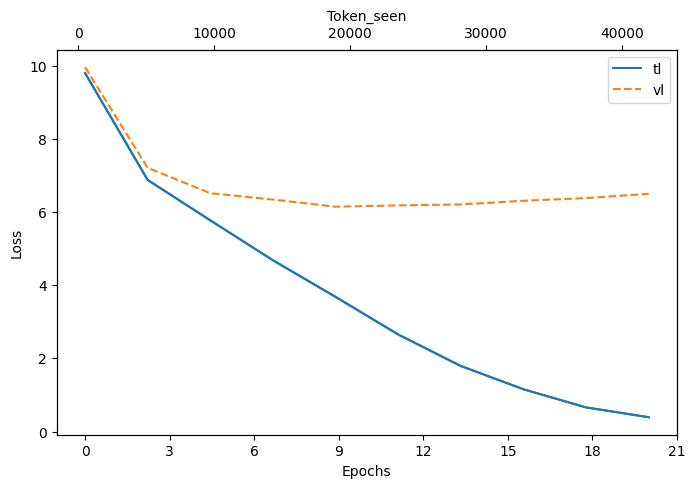

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# tra_loss,vali_loss,track_tok
def plot(epochs,train_loss,valid_loss,track_tok):
  fig,ax = plt.subplots(figsize = (8,5))

  ax.plot(epochs,train_loss,label = 'tl')
  ax.plot(epochs,valid_loss,linestyle = '--',label = 'vl')
  ax.set_xlabel('Epochs')
  ax.set_ylabel("Loss")
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax.legend()

  ax2 = ax.twiny()
  ax2.plot(track_tok,train_loss)
  ax2.set_xlabel('Token_seen')

ep = torch.linspace(0,20,len(tra_loss))
plot(ep,tra_loss,vali_loss,track_tok)

# len(tra_loss)
# len(tra_loss)
# len(train_loader)

##Optimize

In [ ]:
torch.manual_seed(123)
a = torch.randn(10).unsqueeze(0)
a.shape
n = torch.topk(a,5,dim=-1)
# n.values[0][-1]
a

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])

In [ ]:
# a = torch.softmax(a,dim=-1)
# torch.multinomial(a,5)

mask = a<n.values[0][-1]
a = a.masked_fill(mask,-torch.inf)
a

# n = torch.topk(care,top_k, dim=-1)
# min_val = n.values[0][-1]
# mask = care >= min_val
# # return min_val.shape,care.shape,min_val
# care = torch.where(mask,torch.tensor(float('-inf')).to(care.device),care)

tensor([[-0.1115,  0.1204,    -inf,    -inf,    -inf,  0.2093,    -inf,    -inf,
          0.3239, -0.1085]])

In [ ]:
a = torch.softmax(a,dim=-1)
a

tensor([[0.1616, 0.2038, 0.0000, 0.0000, 0.0000, 0.2227, 0.0000, 0.0000, 0.2498,
         0.1621]])

In [ ]:

a[:,(torch.multinomial(a,1)).item()]

tensor([0.2038])

In [ ]:
def generate_all(model,idx,context_length,max_new,temprature = 0,topk = 0):
  model.eval()
  for _ in range(max_new):
    curr_c = idx[:,-context_length:]
    with torch.no_grad():
      ce = model(curr_c)[:,-1,:]
      if topk>0:
        n = torch.topk(ce,topk,dim=-1).values
        mask = ce<n[:,-1]
        ce = ce.masked_fill(mask,-torch.inf)
      if temprature>0:
        ce = ce/temprature
        ce = torch.softmax(ce,dim=-1)
        next = torch.multinomial(ce,1)
        idx = torch.cat((idx,next),dim=-1)
      else:
        ce = torch.softmax(ce,dim=-1)
        next = torch.argmax(ce,dim=-1,keepdim=True)
        idx = torch.cat((idx,next),dim=-1)
  model.train()
  return idx

start = 'Every effort moves'
id_start = text2token(start,tk).to(device)
res =token2text(generate_all(model,id_start,gd['context_length'],10,temprature=0.5,topk=10),tk)
res



'Every effort moves the sunburnt cheeks furrowed by a'

##Load model

In [ ]:
# torch.save(model.state_dict(),'model-my.pth')

# device = 'cuda' if (torch.cuda.is_available()) else 'cpu'
# model_my = DGPT(gd)
# model_my.load_state_dict(torch.load('model-my.pth',map_location=device,weights_only=True))
# model_my.to(device)

# start = 'Every effort moves'
# id_start = text2token(start,tk).to(device)
# res =token2text(generate_all(model_my,id_start,gd['context_length'],10,temprature=0.5,topk=10),tk)
# res


In [ ]:
gd

{'vocab_size': 50257,
 'context_length': 256,
 'emb_dim': 768,
 'n_heads': 12,
 'n_layers': 12,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [ ]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},}

NEW_CONFIG = gd.copy()
NEW_CONFIG.update(model_configs['gpt2-small (124M)'])
NEW_CONFIG.update({"qkv_bias": True})
NEW_CONFIG.update({"context_length":1024})
NEW_CONFIG
LGPT = DGPT(NEW_CONFIG)

In [ ]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 172kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 981kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 197kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:31<00:00, 5.43MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 10.6MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 569kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 640kiB/s]


In [ ]:
LGPT

DGPT(
  (token_emb_matrix): Embedding(50257, 768)
  (pos_emb_matrix): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (tfb): Sequential(
    (0): TFB(
      (normlayer1): NormLayer()
      (normlayer2): NormLayer()
      (mha): MHA(
        (dropout): Dropout(p=0.1, inplace=False)
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (ff): FF(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TFB(
      (normlayer1): NormLayer()
      (normlayer2): NormLayer()
      (mha): MHA(
        (dropout): Dropout(p=0.1, inplace=Fal

In [ ]:
print(settings)
print(params.keys())
print((params['wpe'].shape))
print(len(params['blocks']))
print((params['b'].shape))
print((params['blocks'][2].keys()))

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
(1024, 768)
12
(768,)
dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])


In [ ]:
import numpy as np

def assign(left,right):
  if left.shape != right.shape:
    raise ValueError(f'left:{left.shape}, right:{right.shape}')
  else:
    return torch.nn.Parameter(torch.tensor(right))

def load_weights(gpt,params):
  gpt.token_emb_matrix.weight = assign(gpt.token_emb_matrix.weight, params['wte'])
  gpt.pos_emb_matrix.weight = assign(gpt.pos_emb_matrix.weight,params['wpe'])

  for b in range(len(params['blocks'])):
    q_w,k_w,v_w = np.split(params['blocks'][b]['attn']['c_attn']['w'],3,-1)
    gpt.tfb[b].mha.wq.weight = assign(gpt.tfb[b].mha.wq.weight,q_w.T)
    gpt.tfb[b].mha.wk.weight = assign(gpt.tfb[b].mha.wk.weight,k_w.T)
    gpt.tfb[b].mha.wv.weight = assign(gpt.tfb[b].mha.wv.weight,v_w.T)
    q_b,k_b,v_b = np.split(params['blocks'][b]['attn']['c_attn']['b'],3,-1)
    gpt.tfb[b].mha.wq.bias = assign(gpt.tfb[b].mha.wq.bias,q_b)
    gpt.tfb[b].mha.wk.bias = assign(gpt.tfb[b].mha.wk.bias,k_b)
    gpt.tfb[b].mha.wv.bias = assign(gpt.tfb[b].mha.wv.bias,v_b)
    gpt.tfb[b].mha.out_proj.weight =  assign(gpt.tfb[b].mha.out_proj.weight,params['blocks'][b]['attn']['c_proj']['w'].T)
    gpt.tfb[b].mha.out_proj.bias =    assign(gpt.tfb[b].mha.out_proj.bias,params['blocks'][b]['attn']['c_proj']['b'])


    gpt.tfb[b].ff.layers[0].weight =  assign(gpt.tfb[b].ff.layers[0].weight,params['blocks'][b]['mlp']['c_fc']['w'].T)
    gpt.tfb[b].ff.layers[0].bias =    assign(gpt.tfb[b].ff.layers[0].bias,params['blocks'][b]['mlp']['c_fc']['b'])
    gpt.tfb[b].ff.layers[2].weight =  assign(gpt.tfb[b].ff.layers[2].weight,params['blocks'][b]['mlp']['c_proj']['w'].T)
    gpt.tfb[b].ff.layers[2].bias =    assign(gpt.tfb[b].ff.layers[2].bias,params['blocks'][b]['mlp']['c_proj']['b'])

    gpt.tfb[b].normlayer1.scale =  assign(gpt.tfb[b].normlayer1.scale,params['blocks'][b]['ln_1']['g'])
    gpt.tfb[b].normlayer1.shift =  assign(gpt.tfb[b].normlayer1.shift,params['blocks'][b]['ln_1']['b'])

    gpt.tfb[b].normlayer2.scale =  assign(gpt.tfb[b].normlayer2.scale,params['blocks'][b]['ln_2']['g'])
    gpt.tfb[b].normlayer2.shift =  assign(gpt.tfb[b].normlayer2.shift,params['blocks'][b]['ln_2']['b'])
    gpt.finalNorm.scale = assign(gpt.finalNorm.scale, params['g'])
    gpt.finalNorm.shift = assign(gpt.finalNorm.shift, params['b'])
    gpt.outLayer.weight = assign(gpt.outLayer.weight,params['wte'])


load_weights(LGPT,params)
# params['wte'].shape,LGPT.outLayer.weight.shape
# for i,j in LGPT.tfb[0].normlayer1.named_parameters():
#   print(i,j.shape)
# params['blocks'][0]['ln_1'].keys()
# LGPT.tfb[0].ff.layers[2].weight.shape,params['blocks'][0]['mlp']['c_fc']['w'].shape
# LGPT.outLayer

In [ ]:
# for i,j in LGPT.named_parameters():
#   print(i,'  ',j.shape)

LGPT.to(device)

DGPT(
  (token_emb_matrix): Embedding(50257, 768)
  (pos_emb_matrix): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (tfb): Sequential(
    (0): TFB(
      (normlayer1): NormLayer()
      (normlayer2): NormLayer()
      (mha): MHA(
        (dropout): Dropout(p=0.1, inplace=False)
        (wq): Linear(in_features=768, out_features=768, bias=True)
        (wk): Linear(in_features=768, out_features=768, bias=True)
        (wv): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
      (ff): FF(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TFB(
      (normlayer1): NormLayer()
      (normlayer2): NormLayer()
      (mha): MHA(
        (dropout): Dropout(p=0.1, inplace=Fal

In [ ]:
start = 'What is my name'
id_start = text2token(start,tk).to(device)
res =token2text(generate_all(LGPT,id_start,gd['context_length'],10,temprature=0.5,topk=10),tk)
res

'What is my name?" she asked. "I\'m the one who'

#**Chapter 6**

In [ ]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path= "CFT.zip"
zfolder = 'CFT'
with urllib.request.urlopen(url) as response:
  with open(zip_path,'wb') as f:
    f.write(response.read())

with zipfile.ZipFile(zip_path,'r') as z:
  z.extractall(zfolder)


In [ ]:
import pandas as pd
p = 'CFT/SMSSpamCollection'
df = pd.read_csv(p,sep='\t',header=None,names=['label','text'])
def bd(df):
  spam_num = df[df['label']=='spam'].shape[0]
  ham_subset = df[df['label']=='ham'].sample(spam_num, random_state=123)
  bd = pd.concat((ham_subset,df[df['label']=='spam']))
  return bd
bdata = bd(df)
df['label'].value_counts()

df[df['label']=='spam'].shape[0]
bdata['label'].value_counts()
bdata['label'] = bdata['label'].map({'ham':0,'spam':1})
bdata['label'].value_counts()

In [ ]:
len(bdata[bdata['label']==1])

def random_split(df,train_frac,validation_frac):
  df = df.sample(frac=1,random_state=123).reset_index(drop=True)
  train_end = int(len(df)*train_frac)
  validation_end = train_end+int(len(df)*validation_frac)
  train_data = df[:train_end]
  validation_data = df[train_end:validation_end]
  test_data = df[validation_end:]
  return train_data,validation_data,test_data

a,b,c = random_split(bdata,0.7,0.1)
a.to_csv('FT_train.csv',index=None)
b.to_csv('FT_valid.csv',index=None)
c.to_csv('FT_test.csv',index=None)
len(c)

In [ ]:
test = pd.read_csv('FT_train.csv')
import tiktoken
tk = tiktoken.get_encoding('gpt2')
a = [tk.encode(t) for t in test['text']]
# len(a[0])
print(len(a[5]))
len(test)

In [ ]:
from torch.utils.data import Dataset,DataLoader
class FTdataset(Dataset):
  def __init__(self,csv,tokenizer,max_length=None,pad_token = 50256):
    self.df = pd.read_csv(csv)
    self.encode_texts = [tokenizer.encode(text) for text in self.df['text']]
    if max_length == None:
      self.max_length = self._longest()
    else:
      self.max_length = max_length
      self.encode_texts = [t[:self.max_length] for t in self.encode_texts]
    self.encode_texts = [t+[pad_token]*(self.max_length-len(t)) for t in self.encode_texts]

  def __getitem__(self,i):
    t = torch.tensor(self.encode_texts[i])
    l = torch.tensor(self.df['label'][i])
    return t,l

  def __len__(self):
    return len(self.df)

  def _longest(self):
    longest = 0
    for i in self.encode_texts:
      lo = len(i)
      if longest<lo:
        longest = lo
    return longest

train_d = FTdataset('FT_train.csv',tokenizer=tk)
valid_d = FTdataset('FT_valid.csv',tokenizer=tk)
test_d = FTdataset('FT_test.csv',tokenizer=tk)
torch.manual_seed(123)
# train_d.max_length
train_l = DataLoader(train_d,batch_size=8,shuffle=True,num_workers=0,drop_last=True)
valid_l = DataLoader(valid_d,batch_size=8,num_workers=0,drop_last=False)
test_l = DataLoader(test_d , batch_size=8,num_workers=0,drop_last=False)
len(train_l),len(valid_l),len(test_l)

In [ ]:
NEW_CONFIG

In [ ]:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NEW_CONFIG = gd.copy()
NEW_CONFIG.update(model_configs['gpt2-small (124M)'])
NEW_CONFIG.update({"qkv_bias": True})
NEW_CONFIG.update({"context_length":1024})
NEW_CONFIG
LGPT = DGPT(NEW_CONFIG)
load_weights(LGPT,params)
LGPT = LGPT.to(device)
start = 'Every effort moves'
id_start = text2token(start,tk).to(device)
res =token2text(generate_all(LGPT,id_start,gd['context_length'],10,temprature=0.5,topk=10),tk)
res

In [ ]:
LGPT

In [ ]:
for j in LGPT.parameters():
  j.requires_grad = False
torch.manual_seed(123)
LGPT.outLayer = nn.Linear(NEW_CONFIG['emb_dim'],2)

for j in LGPT.tfb[-1].parameters():
  j.requires_grad = True
for j in LGPT.finalNorm.parameters():
  j.requires_grad = True



In [ ]:
inp = 'Do you have time'
enc = text2token(inp,tk).to(device)
LGPT.to(device)
LGPT.eval()
with torch.no_grad():
  out = LGPT(enc)
logits = out[:,-1,:]
# probas = torch.softmax(logits,dim=-1)
label = torch.argmax(logits,dim=-1)
label
logits.shape
label.shape

In [ ]:
def calc_acc_loader(dataloader,model,device,num_batches):
  model.to(device)

  correct_prediction,num_example = 0,0
  model.eval()
  if num_batches==None:
    num_batches=len(dataloader)
  else:
    num_batches = min(num_batches,len(dataloader))

  for i,(j_inp,j_target) in enumerate(dataloader):
    if i<num_batches:
      j_inp = j_inp.to(device)
      j_target = j_target.to(device)
      with torch.no_grad():
        logit = model(j_inp)[:,-1,:]
        predict_label = torch.argmax(logit,dim=-1)
        num_example+=predict_label.shape[0]
        correct_prediction+=((predict_label == j_target).sum().item())
    else:
      break
  return correct_prediction/num_example

device = 'cuda' if torch.cuda.is_available() else 'cpu'
LGPT.to(device)
torch.manual_seed(123)

train_acc = calc_acc_loader(train_l,LGPT,device=device,num_batches=10)
valid_acc = calc_acc_loader(valid_l,LGPT,device,num_batches=10)
test_acc = calc_acc_loader(test_l,LGPT,device,num_batches=10)

train_acc,valid_acc,test_acc




In [ ]:
def cal_ftloss(inp,tar,model,device):
  inp = inp.to(device)
  tar = tar.to(device)
  logits = model(inp)[:,-1,:]
  loss = torch.nn.functional.cross_entropy(logits,tar)
  return loss

def cal_ftloss_loader(dataloader,model,device,num_batches):
  model.to(device)
  model.eval()
  total_loss = 0
  if num_batches==None:
    num_batches=len(dataloader)
  else:
    num_batches = min(num_batches,len(dataloader))
  for i,(j_inp,j_target) in enumerate(dataloader):
    if i<num_batches:
      j_inp = j_inp.to(device)
      j_target = j_target.to(device)
      # logits = model(j_inp)[:,-1,:]
      loss = cal_ftloss(j_inp,j_target,model,device)
      total_loss+=loss
    else:
      break
  return total_loss/num_batches
with torch.no_grad():
  train_loss = cal_ftloss_loader(train_l,LGPT,device=device,num_batches=5)
  valid_loss = cal_ftloss_loader(valid_l,LGPT,device,num_batches=5)
  test_loss  = cal_ftloss_loader(test_l,LGPT,device,num_batches=5)

train_loss,valid_loss,test_loss

In [ ]:
def evaluate_ft(model,train_loader,valid_loader,device,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = cal_ftloss_loader(train_loader,model,device,eval_iter)
    valid_loss = cal_ftloss_loader(valid_loader,model,device,eval_iter)
  model.train()
  return train_loss,valid_loss

def train_ft(model,train_loader,valid_loader,optimizer,device,num_epochs,eval_freq,eval_iter):
  train_loss,valid_loss,train_accs,valid_accs = [],[],[],[]
  example_seen,global_step = 0,0
  for e in range(num_epochs):
    model.train()
    for inp,tar in train_loader:
      optimizer.zero_grad()
      loss = cal_ftloss(inp,tar,model,device)
      loss.backward()
      optimizer.step()
      example_seen+=inp.shape[0]
      global_step+=1

      if global_step % eval_freq ==0:
        tr_loss,val_loss = evaluate_ft(model,train_loader,valid_loader,device,eval_iter)
        train_loss.append(tr_loss)
        valid_loss.append(val_loss)
        print(f"Ep {e+1} (Step {global_step:06d}):" f"Train loss {tr_loss:.3f}, Val loss {val_loss:.3f}")
        train_acc = calc_acc_loader(train_loader,model,device,eval_iter)
        valid_acc = calc_acc_loader(valid_loader,model,device,eval_iter)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)
  return train_loss,valid_loss,train_accs,valid_accs,example_seen




In [ ]:
torch.manual_seed(123)

optimizer = torch.optim.AdamW(LGPT.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 10
tl,vl,ta,va,exseen = train_ft(LGPT, train_l, valid_l, optimizer, device,num_epochs=num_epochs, eval_freq=50, eval_iter=5)



In [ ]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))


    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(tl),device="cpu")
examples_seen_tensor = torch.linspace(0, exseen, len(tl),device="cpu")
tl = [i.to('cpu') for i in tl]
vl = [i.to('cpu') for i in vl]
# ta = [i.to('cpu') for i in ta]
# va = [i.to('cpu') for i in va]


plot_values(epochs_tensor, examples_seen_tensor, tl, vl)

# tl,vl,ta,va,exseen

In [ ]:
plot_values(epochs_tensor, examples_seen_tensor, ta, va)

In [ ]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb_matrix.weight.shape[0]

    input_ids = input_ids[:min(max_length, supported_context_length)]

    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"

In [ ]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(text_1, LGPT, tk, device, max_length=train_d.max_length))

In [ ]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, LGPT, tk, device, max_length=train_d.max_length
))

#**Chapter 7**

In [ ]:
import urllib
import json
import os

In [ ]:
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json"
fp = 'ift_data.json'
with urllib.request.urlopen(url) as response:
  text_data = response.read().decode('utf-8')

with open(fp,'w',encoding='utf-8') as file:
  file.write(text_data)

with open(fp,'r') as file:
  data = json.load(file)

data[:5],type(data),type(data[0]),len(data)
for i in data[:5]:
  for j in i:
    print(j,i[j])
  print()


instruction Evaluate the following phrase by transforming it into the spelling given.
input freind --> friend
output The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".

instruction Edit the following sentence for grammar.
input He go to the park every day.
output He goes to the park every day.

instruction Convert 45 kilometers to meters.
input 
output 45 kilometers is 45000 meters.

instruction Rewrite this sentence to start with 'Although': Despite the rain, they went for a walk.
input 
output Although it was raining, they went for a walk.

instruction What are the first 10 square numbers?
input 
output 1, 4, 9, 16, 25, 36, 49, 64, 81, 100.



In [ ]:
# def format_input(entry):
#     instruction_text =  f"Below is an instruction that describes a task. Write a response that appropriately completes the request. \n\n### Instruction:\n{entry['instruction']}"

#     input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

#     return instruction_text + input_text

# inp = format_input(data[999])
# resp= f"\n\n### Response:\n{data[999]['output']}"

# print(inp+resp)


In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

inp = format_input(data[999])
resp= f"\n\n### Response:\n{data[999]['output']}"

print(inp+resp)


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [ ]:
len(data)
train_portion = int(len(data)*0.85)
test_portion = int(len(data)*0.1)
valid_portion = len(data)-train_portion-test_portion
train_portion,test_portion,valid_portion

train_ift_data = data[:train_portion]
test_ift_data =  data[train_portion:train_portion+test_portion]
valid_ift_data = data[train_portion+test_portion:]

len(train_ift_data),len(test_ift_data),len(valid_ift_data)

(935, 110, 55)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class InstructionDataset(Dataset):
  def __init__(self,data,tokenizer):
    super().__init__()
    self.data = data
    self.encoded_texts = []
    for entry in data:
      ins_plus_inp = format_input(entry)
      resp_text = f"\n\n### Response:\n{entry['output']}"
      full_text = ins_plus_inp + resp_text
      self.encoded_texts.append(tokenizer.encode(full_text))
  def __getitem__(self,indx):
    return self.encoded_texts[indx]
  def __len__(self):
    return len(self.data)


In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

# print(custom_collate_draft_1(batch))

In [ ]:
# a,b

In [ ]:
def custom_collate_fn(batch,pad_id=50256,ignore_id=-100,allowed_max_length=None,device=device):
  batch_max_length = max(len(item)+1 for item in batch)
  inp_lst,tar_lst=[],[]
  for item in batch:
    new_item=item.copy()
    new_item+=[pad_id]
    padded = new_item+[pad_id]*(batch_max_length-len(new_item))
    inp = torch.tensor(padded[:-1])
    tar = torch.tensor(padded[1:])
    mask = tar==pad_id
    # mask[0]=True
    # tar = torch.where(mask, ignore_id, tar)
    indices=torch.nonzero(mask).squeeze()
    if indices.numel()>1:
      tar[indices[1:]]=ignore_id

    if allowed_max_length is not None:
      inp = inp[:allowed_max_length]
      tar = inp[:allowed_max_length]
    inp_lst.append(inp)
    tar_lst.append(tar)

  inp_lst = torch.stack(inp_lst).to(device)
  tar_lst = torch.stack(tar_lst).to(device)
  return inp_lst,tar_lst



custom_collate_fn(batch)

(tensor([[    0,     1,     2,     3,     4],
         [    5,     6, 50256, 50256, 50256],
         [    7,     8,     9, 50256, 50256]], device='cuda:0'),
 tensor([[    1,     2,     3,     4, 50256],
         [    6, 50256,  -100,  -100,  -100],
         [    8,     9, 50256,  -100,  -100]], device='cuda:0'))

In [ ]:
len(train_ift_data),len(valid_ift_data),len(test_ift_data)

num_workers=0
batch_size=8

torch.manual_seed(123)
train_ift_set = InstructionDataset(train_ift_data,tokenizer=tk)
valid_ift_set = InstructionDataset(valid_ift_data,tokenizer=tk)
test_ift_set = InstructionDataset(test_ift_data,tokenizer=tk)

train_ift_loader = DataLoader(train_ift_set,batch_size=batch_size,collate_fn=custom_collate_fn,shuffle=True,num_workers=num_workers,drop_last=True)
valid_ift_loader = DataLoader(valid_ift_set,batch_size=batch_size,collate_fn=custom_collate_fn,shuffle=False,num_workers=num_workers,drop_last=False)
test_ift_loader = DataLoader(test_ift_set,batch_size=batch_size,collate_fn=custom_collate_fn,shuffle=False,num_workers=num_workers,drop_last=False)


In [ ]:
# for i,t in train_ift_loader:
#   print(i.device,t.device)

In [ ]:
# torch.save(model.state_dict(),'model-my.pth')

# device = 'cuda' if (torch.cuda.is_available()) else 'cpu'
# model_my = DGPT(gd)
# model_my.load_state_dict(torch.load('model-my.pth',map_location=device,weights_only=True))
# model_my.to(device)

# start = 'Every effort moves'
# id_start = text2token(start,tk).to(device)
# res =token2text(generate_all(model_my,id_start,gd['context_length'],10,temprature=0.5,topk=10),tk)
# res


In [ ]:
def generate(model, idx, max_new, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
# print(gd)
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},}

NEW_CONFIG = gd.copy()
NEW_CONFIG.update(model_configs['gpt2-small (124M)'])
NEW_CONFIG.update({"qkv_bias": True})
NEW_CONFIG.update({"context_length":1024})
# print(NEW_CONFIG)
# print(settings)
# print(params.keys())
# print((params['wpe'].shape))
# print(len(params['blocks']))
# print((params['b'].shape))
# print((params['blocks'][2].keys()))
IFTPT = DGPT(NEW_CONFIG)
load_weights(IFTPT,params)
IFTPT.to(device)

start = 'Today is'
id_start = text2token(start,tk).to(device)
res =token2text(generate(model=IFTPT, idx = id_start,context_size=gd['context_length'],max_new=35,temperature=0.5,top_k=10),tk)
res

'Today is a good time to stop by the store, as the, you know, a good time to buy a pair of shoes.\n\nYou know, you know, the,'

In [ ]:
input_text = format_input(valid_ift_data[0])
print(input_text)
# torch.manual_seed(123)
start = input_text
id_start = text2token(start,tk).to(device)
res =token2text(generate_all(IFTPT,id_start,gd['context_length'],max_new=35,temprature=0.5,topk=10),tk).strip()
print("*****************************")
print(res)


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'
*****************************
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

Write a response that appropriately completes the request.

### Response:

Write a response that appropriately completes the request.

###


##Train_IFT

In [ ]:
# cal_loss_loader(model,dataloader,device,num_batch=None)
torch.manual_seed(123)
IFTPT.to(device)
with torch.no_grad():
  tloss = cal_loss_loader(IFTPT,train_ift_loader,device=device,num_batch=5)
  vloss = cal_loss_loader(IFTPT,valid_ift_loader,device=device,num_batch=5)
print(tloss,vloss)

4.2354127883911135 4.0743828296661375


In [ ]:
optimizer = torch.optim.AdamW(IFTPT.parameters(),lr = 0.00005,weight_decay=0.01)
num_epochs=5

In [ ]:
a,b,c = train(IFTPT,train_ift_loader,valid_ift_loader,num_epochs,optimizer,eval_freq=5,eval_iter=None,device=device)

Ep:1 (Step 115) Train loss:0.6952929995183287 valid loss:0.8029652323041644
Ep:2 (Step 231) Train loss:0.5370898896764065 valid loss:0.7446662613323757
Ep:3 (Step 347) Train loss:0.4375175689828807 valid loss:0.7166927967752729
Ep:4 (Step 463) Train loss:0.3595290767221615 valid loss:0.71275680405753
Ep:5 (Step 579) Train loss:0.30496822246189775 valid loss:0.71815082856587


In [ ]:
torch.manual_seed(123)
for entry in test_ift_data[:3]:
    input_text = format_input(entry)


    token_ids = generate(IFTPT,idx=text2token(input_text, tk).to(device),max_new=256,context_size=gd["context_length"],eos_id=50256)
    generated_text = token2text(token_ids, tk)
    response_text = generated_text[len(input_text):].replace("### Output:", "").strip()
    # response_text = generated_text[len(input_text):]

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is very fast.


###
###

###

###

###

###
###
###
###

###

###
###

###
###

###

###

###
###
###

###
###
###

###

###

###

###

###

###
###

###

###

###

###

###
###

###

###

###

###

###

###


###

###

###
###

###


###
###

###

###

###


###

###

###


###

###
###

###

###

###
###

###
###

###
###


###
###

###

###

###

###

###

###

###
###

###

###

###

###

###
###
###

###

###

###

###
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thu

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

##

#A

In [ ]:
import torch
a = torch.tensor([[1,2,3],[4,5,6]])
a.shape
a

tensor([[1, 2, 3],
        [4, 5, 6]])

In [ ]:
# a.view(3,2)
# a.reshape(3,2)
# a = torch.tensor([1,2,3,4,5,6])
# a.shape
# a.reshape(3,2)
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
c = torch.tensor([7,8,9])

a.unsqueeze_(0)
b.unsqueeze_(0)
c.unsqueeze_(0)
d1 = torch.cat((a,b,c),dim=0)
d2 = d1

d = torch.stack((d1,d2),dim=0)
d
# a.shape
# torch.stack((a,b),dim=0)


tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]],

        [[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [ ]:
import torch.nn.functional as F
# from torch.autograd import grad
y = torch.tensor([1.0])
x1 = torch.tensor([1.1])
w1 = torch.tensor([2.2],requires_grad=True)
b = torch.tensor([0.0],requires_grad=True)

# w1 = torch.tensor([2.2])
# b = torch.tensor([0.0])


z = torch.sigmoid(x1*w1+b)
loss = F.binary_cross_entropy(z,y)
loss.backward()
w1.grad,b.grad

# dw1 = grad(loss,w1,retain_graph=True)
# db = grad(loss,b,retain_graph=True)
# db



(tensor([-0.0898]), tensor([-0.0817]))

In [ ]:
import torch.nn as nn

In [ ]:
class NN(nn.Module):
  def __init__(self,inc,out):
    super().__init__()
    self.NN = nn.Sequential(
        nn.Linear(inc,30,bias=True),
        nn.ReLU(),
        nn.Linear(30,20,bias=True),
        nn.ReLU(),
        nn.Linear(20,out)
    )

  def forward(self,x):
    return self.NN(x)

m = NN(50,3)

for i,j in m.named_parameters():
  print(i)

sum(p.numel() for p in m.parameters())
print(m.NN[0].weight.shape)
# a = torch.tensor([[1,2,3,4],[5,6,7,8],[0,0,0,0]])
# [p.numel() for p in a]


NN.0.weight
NN.0.bias
NN.2.weight
NN.2.bias
NN.4.weight
NN.4.bias
torch.Size([30, 50])


In [ ]:
torch.manual_seed(123)
x = torch.randn((1,50))
with torch.no_grad():
  out = m(x)
out = torch.softmax(out,dim=-1)
out

tensor([[0.3753, 0.3453, 0.2794]])

In [ ]:
x_train = torch.tensor([[-1.2,3.1],[-0.9,2.9],[-0.5,2.6],[2.3,-1.1],[2.7,-1.5]])

y_train=torch.tensor([0,0,0,1,1])

x_test = torch.tensor([[-0.8,2.8],[2.6,-1.6]])
y_test = torch.tensor([0,1])

from torch.utils.data import Dataset,DataLoader

class Toy(Dataset):
  def __init__(self,X,Y):
    super().__init__()
    self.x = X
    self.y = Y
  def __getitem__(self,indx):
    return self.x[indx],self.y[indx]
  def __len__(self):
    return len(self.x)

train_toy = Toy(x_train,y_train)
test_toy = Toy(x_test,y_test)

len(train_toy)

tr_loader = DataLoader(train_toy,batch_size=2,shuffle=True,num_workers=0,drop_last=True)
test_loader = DataLoader(test_toy,batch_size=2,shuffle=False,num_workers=0,)

# for i,j in test_loader:
#   print(i,j)

torch.manual_seed(123)
tnn = NN(2,2)
optimizer = torch.optim.SGD(tnn.parameters(),lr=0.5)
num_epochs=10

for e in range(num_epochs):
  tnn.train()
  for i,(x,y) in enumerate(tr_loader):
    logit = tnn(x)
    loss = F.cross_entropy(logit,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"ep:{e+1} batch:{i}/ {len(tr_loader)} loss: {loss}")






ep:1 batch:0/ 2 loss: 0.7487356662750244
ep:1 batch:1/ 2 loss: 0.6450306177139282
ep:2 batch:0/ 2 loss: 0.44225579500198364
ep:2 batch:1/ 2 loss: 0.12562280893325806
ep:3 batch:0/ 2 loss: 0.026905544102191925
ep:3 batch:1/ 2 loss: 0.0043272399343550205
ep:4 batch:0/ 2 loss: 0.01814688928425312
ep:4 batch:1/ 2 loss: 0.01870044507086277
ep:5 batch:0/ 2 loss: 0.0011886745924130082
ep:5 batch:1/ 2 loss: 0.019673030823469162
ep:6 batch:0/ 2 loss: 0.011796331033110619
ep:6 batch:1/ 2 loss: 0.0025485435035079718
ep:7 batch:0/ 2 loss: 0.0009615547023713589
ep:7 batch:1/ 2 loss: 0.008330076932907104
ep:8 batch:0/ 2 loss: 0.0037992321886122227
ep:8 batch:1/ 2 loss: 0.0008084033615887165
ep:9 batch:0/ 2 loss: 0.0023475568741559982
ep:9 batch:1/ 2 loss: 0.0017554151127114892
ep:10 batch:0/ 2 loss: 0.005513850133866072
ep:10 batch:1/ 2 loss: 0.001594828674569726
